In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyreadr

# to plot interaction networks of As and Ss; must be version >= 3.0 due to
# an update to MatPlotLib
from scipy.stats import nbinom
import statsmodels.api as sm
from statsmodels.formula.api import glm
import anndata as ad


PAM50genes = [
    "EGFR",    "CDH3",
    "PHGDH",    "ACTR3B",
    "FOXC1",    "MIA",
    "MYC",    "FGFR4",
    "MDM2",    "MLPH",
    "KRT14",    "BCL2",
    "SFRP1",    "KRT5",
    "KRT17",    "SLC39A6",
    "ESR1",    "CXXC5",
    "BLVRA",    "FOXA1",
    "GPR160",    "NAT1",
    "MAPT",    "PGR",
    "BAG1",    "TMEM45B",
    "ERBB2",    "GRB7",
    "MMP11",    "CDC20",
    "MKI67",    "CCNE1",
    "CENPF",    "NUF2",
    "EXO1",    "KIF2C",
    "ORC6",    "ANLN",
    "CDC6",    "RRM2",
    "UBE2T",    "NDC80",
    "CEP55",    "MELK",
    "TYMS",    "CCNB1",
    "BIRC5",    "MYBL2",
    "PTTG1",    "UBE2C"
]

PAM50genes = PAM50genes[::-1]
print(PAM50genes)

num_bins = 100


['UBE2C', 'PTTG1', 'MYBL2', 'BIRC5', 'CCNB1', 'TYMS', 'MELK', 'CEP55', 'NDC80', 'UBE2T', 'RRM2', 'CDC6', 'ANLN', 'ORC6', 'KIF2C', 'EXO1', 'NUF2', 'CENPF', 'CCNE1', 'MKI67', 'CDC20', 'MMP11', 'GRB7', 'ERBB2', 'TMEM45B', 'BAG1', 'PGR', 'MAPT', 'NAT1', 'GPR160', 'FOXA1', 'BLVRA', 'CXXC5', 'ESR1', 'SLC39A6', 'KRT17', 'KRT5', 'SFRP1', 'BCL2', 'KRT14', 'MLPH', 'MDM2', 'FGFR4', 'MYC', 'MIA', 'FOXC1', 'ACTR3B', 'PHGDH', 'CDH3', 'EGFR']


In [ ]:
# Get Expression Data

### SIMULATED DATA ###
#path_to_data = "/path/to/0_synthetic_data/anndata/"
#data_folder = "simulated_stratified_by_subtype_batch_dups"
#dataset = "/train_validation/anndata.stratified.N2_min.Formatted_for_PREFFECT.tau_1.h5ad"

### THIRD PARTY DATA
#path_to_data = "/path/to/third_party/"

#data_folder = "GSE47462_third_party_ffpe"
#dataset = "/train_validation/GSE47462_19K_tumor.tau_1.h5ad"

# data_folder = "GSE209998_third_party_ffpe"
# dataset = "/train_validation/GSE209998_19K_tumor.tau_1.h5ad"

#data_folder = "GSE181466_third_party_ffpe"
#dataset = "/train_validation/GSE181466_19K.tau_1.h5ad"

#data_folder = "GSE120795_third_party_ffpe"
#dataset = "/train_validation/GSE120795_19K.tau_1.h5ad"

# Currently, these datasets have Ensemble Gene Name problem; must convert first!
#data_folder = "GSE167977_third_party_ffpe"
#dataset = "/train_validation/GSE167977_19K.tau_1.h5ad"

#data_folder = "CountMeIn_BC_only_third_party_ffpe"
#dataset = "/train_validation/gdc_download.CMI_BC_Only_19K.tau_1.h5ad"

# Our DCIS data
path_to_data = "/path/to/"
data_folder = "our_dcis"
dataset = "/train_validation/expression_counts.Jan2023_1_2_and_2_2_19K.tau_1.h5ad"

# Library Normalization
# Types: Median [Median Centered], Fraction [Divide by LS * 10000], and None or NoLibNorm

#lib_correction = "NoLibNorm"
#lib_correction = "Fraction"
lib_correction = "Median"

path_to_save = "/path/to/6_dispersion/9_Exploring_NB_In_PAM50/"
pdf_save = path_to_save + data_folder + ".NB_PAM50." + lib_correction + ".pdf"
table_save = path_to_save + data_folder + ".NB_PAM50." + lib_correction + ".csv"


anndata_test = ad.read_h5ad(path_to_data + data_folder + dataset)
expr_matrix = anndata_test.X
gene_order = anndata_test.var['gene']


# checking if matrix given is a tensor or a numpy array
if isinstance(expr_matrix, np.ndarray):
    cleaned_matrix = np.nan_to_num(expr_matrix)
else:
    cleaned_matrix = np.nan_to_num(expr_matrix.detach().cpu().numpy())

anndata_test.X = cleaned_matrix

In [ ]:
# Gene Name Conversion
file = "/path/to/ensemble_to_refseq_gene_name_table.rds"

gene_converter = pyreadr.read_r(file)
gene_converter = gene_converter[None]

# only do this step if gene names are all Ensemble genes
all_start_with_ENSG = all(gene_id.startswith('ENSG') for gene_id in gene_order)

if (all_start_with_ENSG):
    filtered_df = gene_converter[gene_converter['gene_id'].isin(gene_order)]
    gene_mapping = pd.Series(filtered_df.gene_name.values,index=filtered_df.gene_id).to_dict()

    gene_ids_list = [gene_mapping[gene_name] for gene_name in gene_order if gene_name in gene_mapping]

    # make sure they are equal so we don't shift gene order
    print(len(gene_order))
    print(len(gene_ids_list))

    gene_order = gene_ids_list



19231
19231


In [17]:
# normalize library size
anndata_test.obs['library_size'] = anndata_test.X.sum(axis=1)

if (lib_correction == "Median"):
    # Calculate the median library size
    median_library_size = np.median(anndata_test.obs['library_size'].values[:, None])
    scaling_factors = median_library_size / anndata_test.obs['library_size'].values
    scaling_factors_reshaped = scaling_factors[:, None]
    cleaned_matrix = np.round(anndata_test.X * scaling_factors_reshaped)
    
elif (lib_correction == "Fraction"):

    # Normalize the data by library size
    cleaned_matrix = np.round((cleaned_matrix / anndata_test.obs['library_size'].values[:, None])*1000000)



In [18]:

# which gene_order are in PAM50_genes; no repeat genes in AnnData tables
if gene_order is not None:
    gene_indices = {gene: index for index, gene in enumerate(gene_order)}
    gene_match = [
        gene_indices[gene] if gene in gene_indices else None for gene in PAM50genes
    ]

    indices = [index for index in gene_match if index is not None]

    present_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is not None
    ]

    cleaned_matrix = cleaned_matrix[:, indices]
    print("PAM50 Genes Found: ", len(cleaned_matrix[0]))

    missing_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is None
    ]

    # Print missing PAM50 genes
    print("Missing PAM50 Genes: ", missing_pam50)
else:
    print("Missing names of genes (required)")

# I want to normalize over all samples
df = pd.DataFrame(cleaned_matrix)

print(cleaned_matrix)

PAM50 Genes Found:  50
Missing PAM50 Genes:  []
[[2.240e+02 1.500e+02 5.460e+02 ... 4.930e+02 8.000e+00 2.700e+01]
 [5.430e+02 5.000e+00 1.960e+02 ... 4.559e+03 1.439e+03 3.566e+03]
 [1.500e+01 2.270e+02 6.600e+01 ... 3.354e+03 1.649e+03 1.252e+03]
 ...
 [6.300e+01 3.020e+02 5.010e+02 ... 3.185e+03 7.700e+02 1.639e+03]
 [8.000e+00 2.900e+01 8.400e+01 ... 2.200e+02 8.760e+02 8.200e+01]
 [0.000e+00 0.000e+00 7.687e+03 ... 6.668e+03 4.271e+03 9.533e+03]]


In [ ]:
# now lets draw the plots
count = 0
df_final = pd.DataFrame(columns=['Gene', 'Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"])

# added feature: Draw histograms and NB parameters of PAM50 genes

with PdfPages(pdf_save) as pdf:

    for gene in present_pam50:
        print(gene)
        gene_data = cleaned_matrix[:, count].flatten()
        
        # trimmed mean to remove outliers
        n = len(gene_data)
        trim_percent = 0
        elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
        sorted_data = np.sort(gene_data)
        
        if (elements_to_trim > 0):
            trimmed_data = sorted_data[elements_to_trim:-elements_to_trim]
        else: 
            trimmed_data = sorted_data
        
        # calculate NB parameters
        mu = np.mean(trimmed_data)
        variance = np.var(trimmed_data, ddof=1)

        # Calculate dispersion parameter (theta) using method of moments
        theta = mu**2 / (variance - mu)
        count = count + 1

        # somehow the r paramater is computed the same way
        r = mu**2 / (variance - mu)
        p = r / (r + mu)
        
        x = np.arange(0, np.max(trimmed_data) + 1)  # Range of values
        pmf = nbinom.pmf(x, r, p)

        # getting a summary description of the NB parameters using statsmodels.api
        X = np.ones_like(trimmed_data)
        model = sm.NegativeBinomial(trimmed_data, X)
        results = model.fit(disp=0)

        p_values = results.pvalues
        coeffs = results.params
        
        # draw figure and table of data into PDF
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
        
        # draw figure
        n, bins, patches = ax1.hist(trimmed_data, bins=num_bins, density=True, alpha=0.5, label='Expression Data')
        
        ax1.plot(x, pmf, 'g-', label='Negative Binomial PMF')  
        ax1.set_ylim(0, max(n)*1.1)
        
        ax1.set_xlabel("Counts")
        ax1.set_ylabel("Fraction")
        ax1.set_title(gene)

        # draw table of values
        ax2.axis('off')  # Hide the axis

        df = pd.DataFrame({
            'Parameter': ['Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"],
            'Value': [mu, variance, round(theta, 5), round(p, 5), round(r, 5), round(coeffs[0], 4), round(p_values[0], 5), round(coeffs[1],4), round(p_values[1],5)]
        })
        new_row = {
            'Gene': gene,
            'Mean(mu)': mu, 
            'Variance': variance, 
            'Dispersion': round(theta, 5),
            "p": round(p, 5),
            "r": round(r, 5),
            "const_coeff": round(coeffs[0], 4), 
            "const_pval": round(p_values[0], 4), 
            "alpha_const": round(coeffs[1],4), 
            "alpha_pval": round(p_values[1],4),
        
        
        }

        df_final = df_final.append(new_row, ignore_index=True)

        tbl = ax2.table(cellText=df.values, colLabels=df.columns, loc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8)
        tbl.scale(1.2, 1.2)  # may need to adjust scaling for your data

        plt.tight_layout()
        
        pdf.savefig(fig)
        plt.close() 

In [20]:
print(df_final)
df_final.to_csv(table_save, index=False)

       Gene      Mean(mu)       Variance Dispersion        p        r  \
0     UBE2C     294.13974    564414.1875    0.15337  0.00052  0.15337   
1     PTTG1    221.401749   351001.96875    0.13974  0.00063  0.13974   
2     MYBL2   1050.668091     10185393.0    0.10839   0.0001  0.10839   
3     BIRC5    165.427948  189371.453125    0.14464  0.00087  0.14464   
4     CCNB1    501.318787     2304072.75     0.1091  0.00022   0.1091   
5      TYMS    200.681229    101694.5625     0.3968  0.00197   0.3968   
6      MELK    359.890839     585898.875     0.2212  0.00061   0.2212   
7     CEP55     411.97818      7190359.0    0.02361  0.00006  0.02361   
8     NDC80    322.851532      1164254.0    0.08955  0.00028  0.08955   
9     UBE2T    173.825333  259373.578125    0.11657  0.00067  0.11657   
10     RRM2    552.296936     601109.125    0.50792  0.00092  0.50792   
11     CDC6    653.519653      6435324.0    0.06637   0.0001  0.06637   
12     ANLN   1151.244507     3279899.75    0.40423

In [ ]:
# Our DCIS data
path_to_data = "/path/to/"
data_folder = "our_dcis"
dataset = "/train_validation/expression_counts.Jan2023_1_2_and_2_2_19K.tau_1.h5ad"

# Library Normalization
# Types: Median [Median Centered], Fraction [Divide by LS * 10000], and None or NoLibNorm
#lib_correction = "NoLibNorm"
#lib_correction = "Fraction"
lib_correction = "Median"

# by subtype analysis. Exclusive to DCIS data only.
path_to_save = "/path/to/6_dispersion/9_Exploring_NB_In_PAM50/"
pdf_save = path_to_save + data_folder + ".NB_PAM50." + lib_correction + ".Subtype.pdf"
table_save = path_to_save + data_folder + ".NB_PAM50." + lib_correction + ".Subtype.csv"


anndata_test = ad.read_h5ad(path_to_data + data_folder + dataset)
expr_matrix = anndata_test.X
gene_order = anndata_test.var['gene']
subtype_info = anndata_test.obs['subtype']

# checking if matrix given is a tensor or a numpy array
if isinstance(expr_matrix, np.ndarray):
    cleaned_matrix = np.nan_to_num(expr_matrix)
else:
    cleaned_matrix = np.nan_to_num(expr_matrix.detach().cpu().numpy())

anndata_test.X = cleaned_matrix

# Gene Name Conversion
file = "/path/to/ensemble_to_refseq_gene_name_table.rds"

gene_converter = pyreadr.read_r(file)
gene_converter = gene_converter[None]

# only do this step if gene names are all Ensemble genes
all_start_with_ENSG = all(gene_id.startswith('ENSG') for gene_id in gene_order)

if (all_start_with_ENSG):
    filtered_df = gene_converter[gene_converter['gene_id'].isin(gene_order)]
    gene_mapping = pd.Series(filtered_df.gene_name.values,index=filtered_df.gene_id).to_dict()

    gene_ids_list = [gene_mapping[gene_name] for gene_name in gene_order if gene_name in gene_mapping]
    gene_order = gene_ids_list

# normalize library size
anndata_test.obs['library_size'] = anndata_test.X.sum(axis=1)

if (lib_correction == "Median"):
    # Calculate the median library size
    median_library_size = np.median(anndata_test.obs['library_size'].values[:, None])
    scaling_factors = median_library_size / anndata_test.obs['library_size'].values
    scaling_factors_reshaped = scaling_factors[:, None]
    cleaned_matrix = np.round(anndata_test.X * scaling_factors_reshaped)
    
elif (lib_correction == "Fraction"):

    # Normalize the data by library size
    cleaned_matrix = np.round((cleaned_matrix / anndata_test.obs['library_size'].values[:, None])*10000000)

# which gene_order are in PAM50_genes; no repeat genes in AnnData tables
if gene_order is not None:
    gene_indices = {gene: index for index, gene in enumerate(gene_order)}
    gene_match = [
        gene_indices[gene] if gene in gene_indices else None for gene in PAM50genes
    ]

    indices = [index for index in gene_match if index is not None]

    present_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is not None
    ]

    cleaned_matrix = cleaned_matrix[:, indices]
    print("PAM50 Genes Found: ", len(cleaned_matrix[0]))

    missing_pam50 = [
        gene for gene, idx in zip(PAM50genes, gene_match) if idx is None
    ]

    # Print missing PAM50 genes
    print("Missing PAM50 Genes: ", missing_pam50)
else:
    print("Missing names of genes (required)")

# I want to normalize over all samples
df = pd.DataFrame(cleaned_matrix)

PAM50 Genes Found:  50
Missing PAM50 Genes:  []


In [ ]:
# now lets draw the PAM50 distribution on a per-subtype basis
count = 0
df_final = pd.DataFrame(columns=['Gene', 'Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"])

# added feature: Draw histograms and NB parameters of PAM50 genes

with PdfPages(pdf_save) as pdf:

    for gene in present_pam50:
        print(gene)
        gene_data = cleaned_matrix[:, count].flatten()
        count = count + 1
        
        # we split data by subtype
        data = pd.DataFrame({
            'Numbers': gene_data,
            'Categories': subtype_info
        })
        grouped = data.groupby('Categories')['Numbers'].apply(list)

        

        for subtype, subtype_expression in grouped.items():
            if (subtype == "NaN"):
                continue
            print(subtype)
            
            n = len(subtype_expression)
            trim_percent = 0
            elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
            sorted_data = np.sort(subtype_expression)
            
            if (elements_to_trim > 0):
               print (elements_to_trim)
               subtype_expression = sorted_data[elements_to_trim:-elements_to_trim]



            # calculate NB parameters
            mu = np.mean(subtype_expression)
            variance = np.var(subtype_expression, ddof=1)

            # Calculate dispersion parameter (theta) using method of moments
            theta = mu**2 / (variance - mu)

            # somehow the r paramater is computed the same way
            r = mu**2 / (variance - mu)
            p = r / (r + mu)
            
            x = np.arange(0, np.max(subtype_expression) + 1)  # Range of values
            pmf = nbinom.pmf(x, r, p)

            # getting a summary description of the NB parameters using statsmodels.api
            X = np.ones_like(subtype_expression)
            model = sm.NegativeBinomial(subtype_expression, X)
            results = model.fit(disp=0)

            p_values = results.pvalues
            coeffs = results.params
            
            # draw figure and table of data into PDF
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
            
            # draw figure
            n, bins, patches = ax1.hist(subtype_expression, bins=num_bins, density=True, alpha=0.5, label='Expression Data')
            
            ax1.plot(x, pmf, 'g-', label='Negative Binomial PMF')  
            ax1.set_ylim(0, max(n)*1.1)
            
            ax1.set_xlabel("Counts")
            ax1.set_ylabel("Fraction")
            title = gene + "_" + subtype
            ax1.set_title(title)

            # draw table of values
            ax2.axis('off')  # Hide the axis

            df = pd.DataFrame({
                'Parameter': ['Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"],
                'Value': [mu, variance, round(theta, 5), round(p, 5), round(r, 5), round(coeffs[0], 4), round(p_values[0], 5), round(coeffs[1],4), round(p_values[1],5)]
            })
            new_row = {
                'Gene': gene,
                'Subtype': subtype,
                'Mean(mu)': mu, 
                'Variance': variance, 
                'Dispersion': round(theta, 5),
                "p": round(p, 10),
                "r": round(r, 10),
                "const_coeff": round(coeffs[0], 4), 
                "const_pval": round(p_values[0], 4), 
                "alpha_const": round(coeffs[1],4), 
                "alpha_pval": round(p_values[1],4),
            
            
            }

            df_final = df_final.append(new_row, ignore_index=True)

            tbl = ax2.table(cellText=df.values, colLabels=df.columns, loc='center')
            tbl.auto_set_font_size(False)
            tbl.set_fontsize(8)
            tbl.scale(1.2, 1.2)  # may need to adjust scaling for your data

            plt.tight_layout()
            
            pdf.savefig(fig)
            plt.close() 



df_final.to_csv(table_save, index=False)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom
import scipy.optimize as opt

def trim_outliers(data_list, trim_percent):
    n = len(data_list)
    elements_to_trim = int(np.floor(trim_percent / 100.0 * n))
    sorted_data = np.sort(data_list)
    elements_to_trim = 2
    
    if elements_to_trim > 0:
        trimmed_data = sorted_data[elements_to_trim:-elements_to_trim]
        #trimmed_data = sorted_data[:-elements_to_trim]
    else:
        trimmed_data = sorted_data
    #print("trim count", elements_to_trim)
    
    return trimmed_data

def fit_negative_binomial(data):
    mean = np.mean(data)
    var = np.var(data)

    # Initial guesses for mu and theta
    mu_init = mean
    theta_init = (mean**2) / (var - mean) if var > mean else 1.0

    def nbinom_neg_log_likelihood(params, data):
        mu, theta = params
        if theta <= mu:  # Prevent invalid theta
            return np.inf
        r = mu**2 / (theta - mu)
        p = mu / (theta + mu)
        return -np.sum(nbinom.logpmf(data, r, p))

    result = opt.minimize(nbinom_neg_log_likelihood, [mu_init, theta_init], args=(data,), bounds=[(0.01, None), (0.01, None)])
    mu, theta = result.x
    return mu, theta

UBE2C
Number of zeros in each category:
Categories
Basal      6
Her2       4
LumA      21
LumB       3
Normal    13
Name: Numbers, dtype: int64


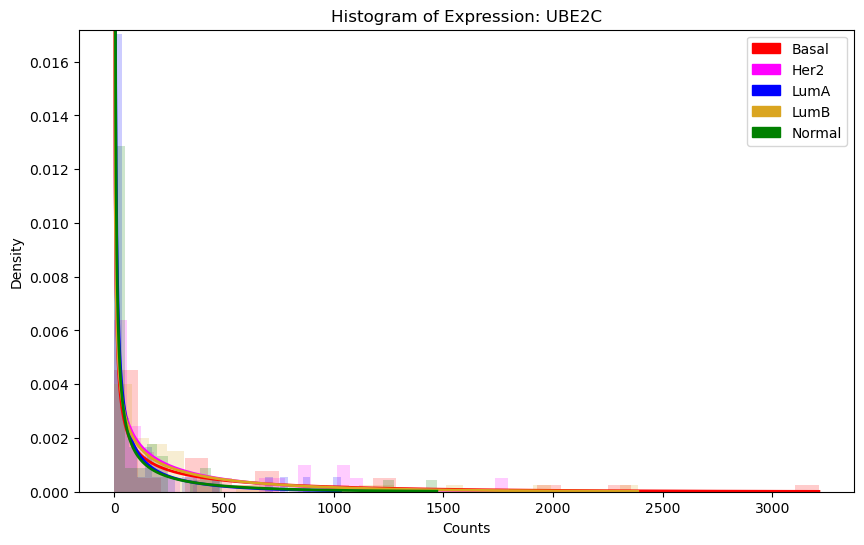

PTTG1
Number of zeros in each category:
Categories
Basal     10
Her2       4
LumA      22
LumB       8
Normal    15
Name: Numbers, dtype: int64


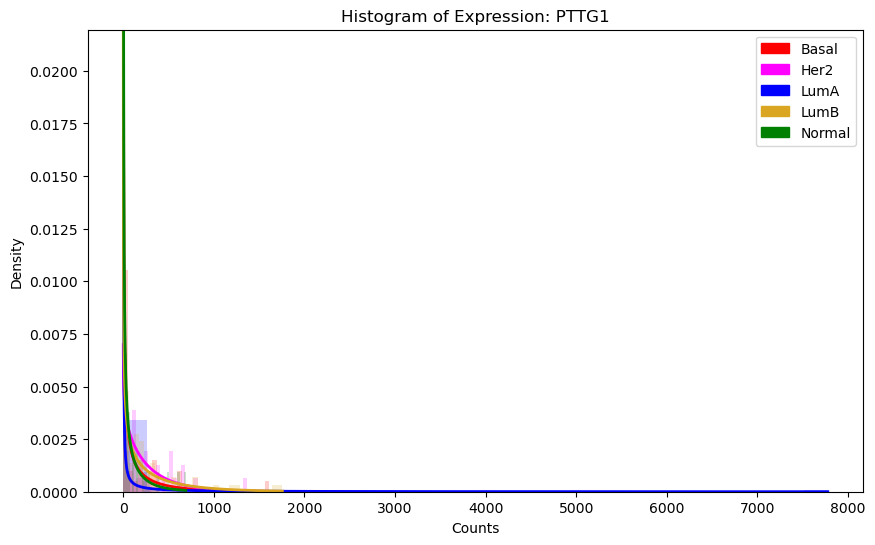

MYBL2
Number of zeros in each category:
Categories
Basal      0
Her2       1
LumA      15
LumB       1
Normal    11
Name: Numbers, dtype: int64


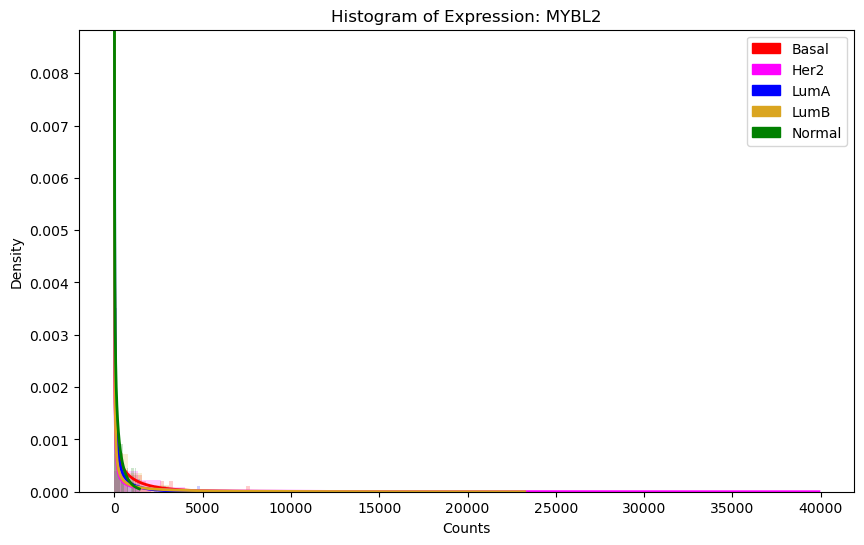

BIRC5
Number of zeros in each category:
Categories
Basal      8
Her2       4
LumA      16
LumB       7
Normal    15
Name: Numbers, dtype: int64


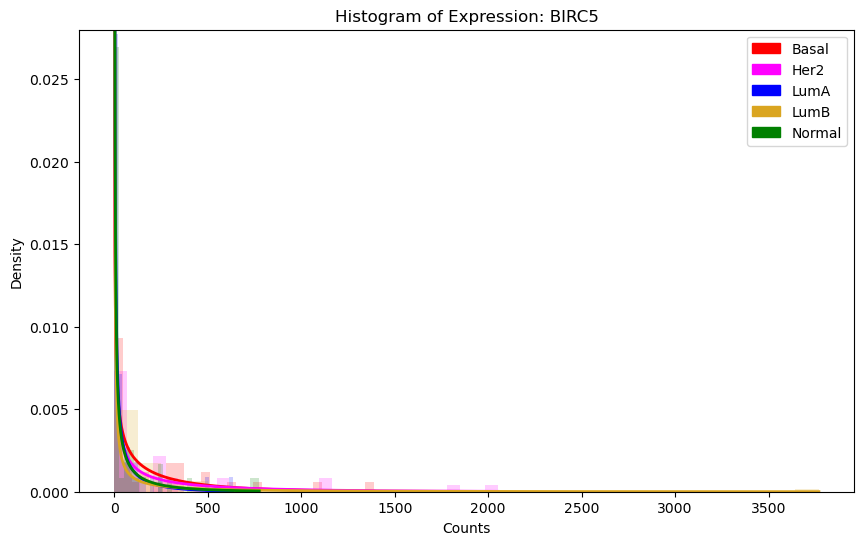

CCNB1
Number of zeros in each category:
Categories
Basal     3
Her2      3
LumA      8
LumB      5
Normal    6
Name: Numbers, dtype: int64


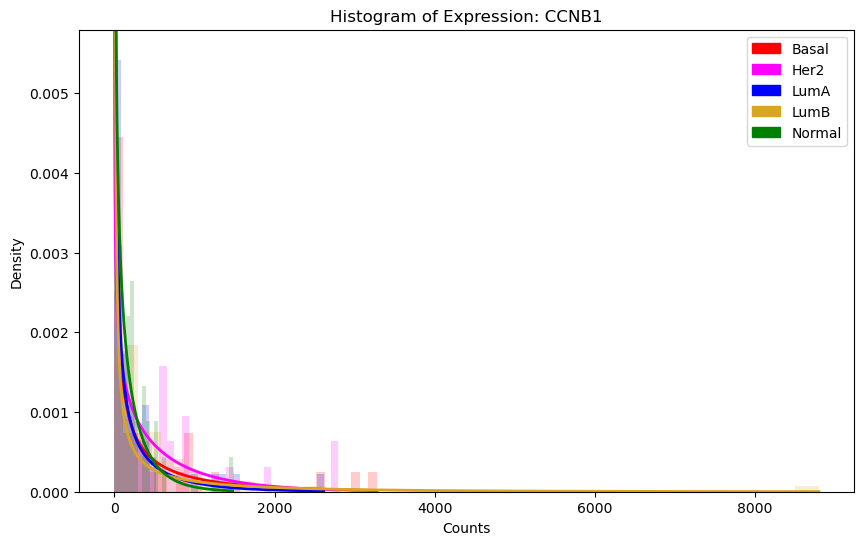

TYMS
Number of zeros in each category:
Categories
Basal     3
Her2      1
LumA      8
LumB      3
Normal    2
Name: Numbers, dtype: int64


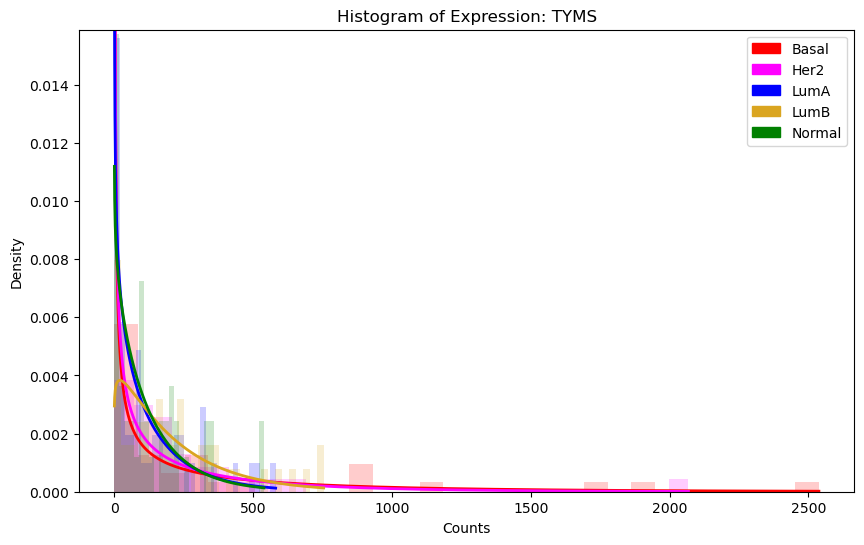

MELK
Number of zeros in each category:
Categories
Basal      5
Her2       2
LumA      11
LumB       1
Normal     9
Name: Numbers, dtype: int64


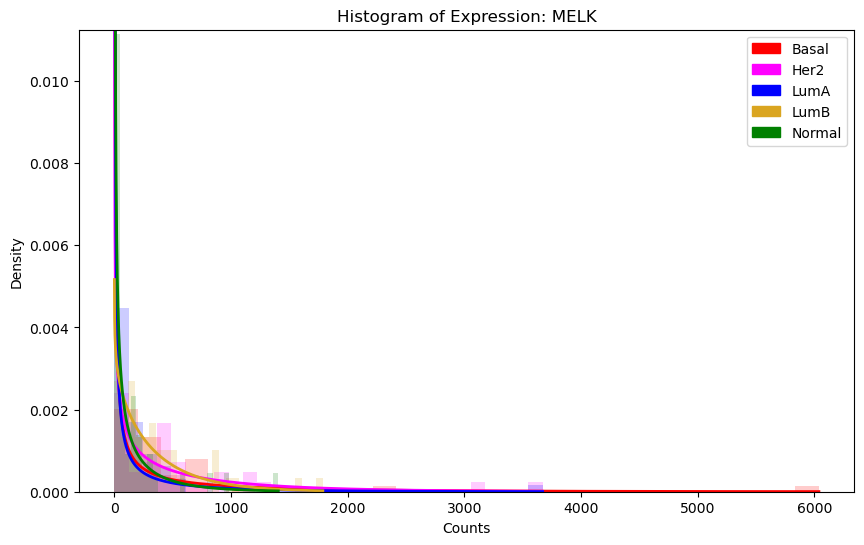

CEP55
Number of zeros in each category:
Categories
Basal      6
Her2       1
LumA      14
LumB       3
Normal    17
Name: Numbers, dtype: int64


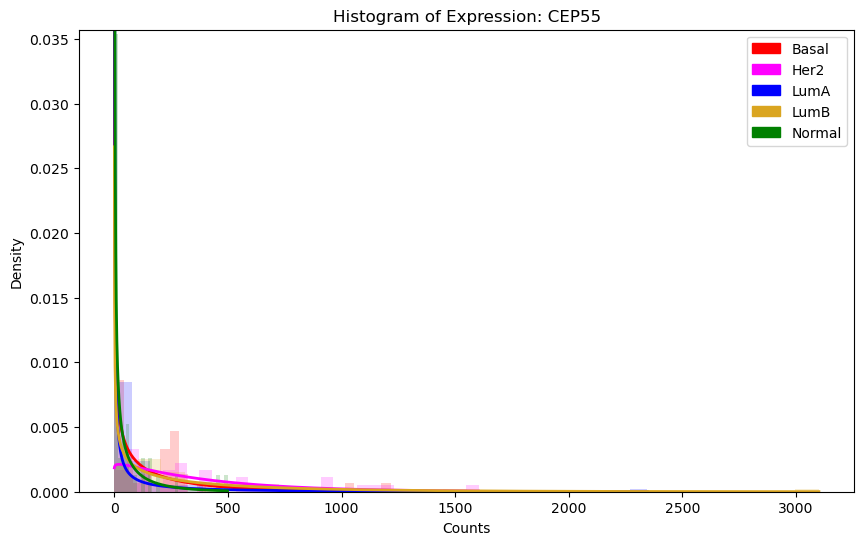

NDC80
Number of zeros in each category:
Categories
Basal      3
Her2       3
LumA      12
LumB       4
Normal     7
Name: Numbers, dtype: int64


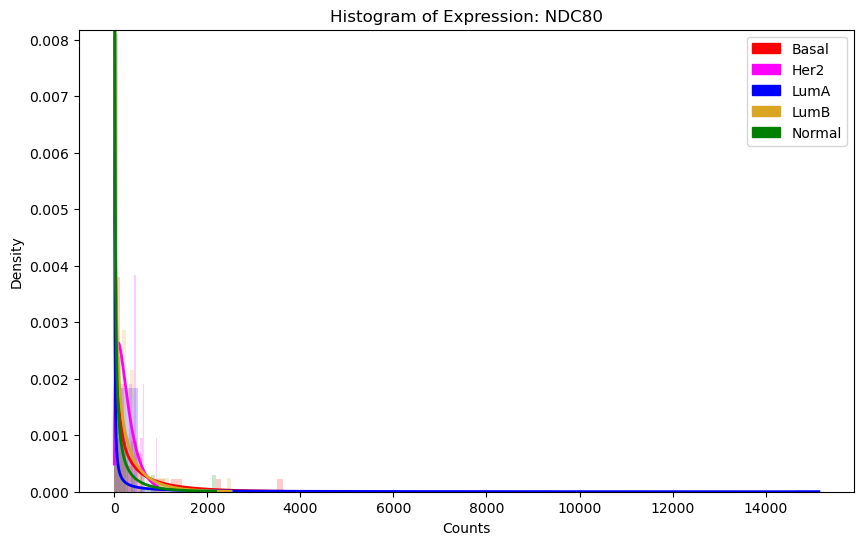

UBE2T
Number of zeros in each category:
Categories
Basal     12
Her2       6
LumA      16
LumB       8
Normal    19
Name: Numbers, dtype: int64


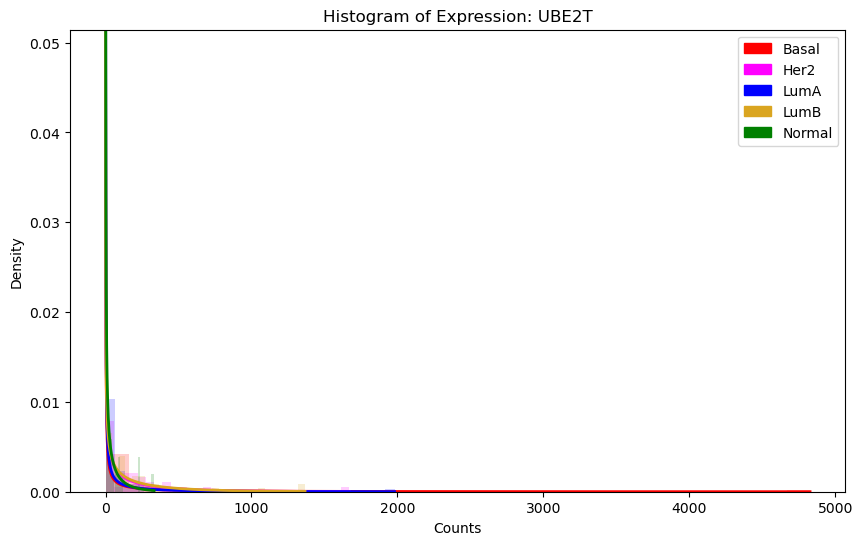

RRM2
Number of zeros in each category:
Categories
Basal     1
Her2      1
LumA      8
LumB      3
Normal    6
Name: Numbers, dtype: int64


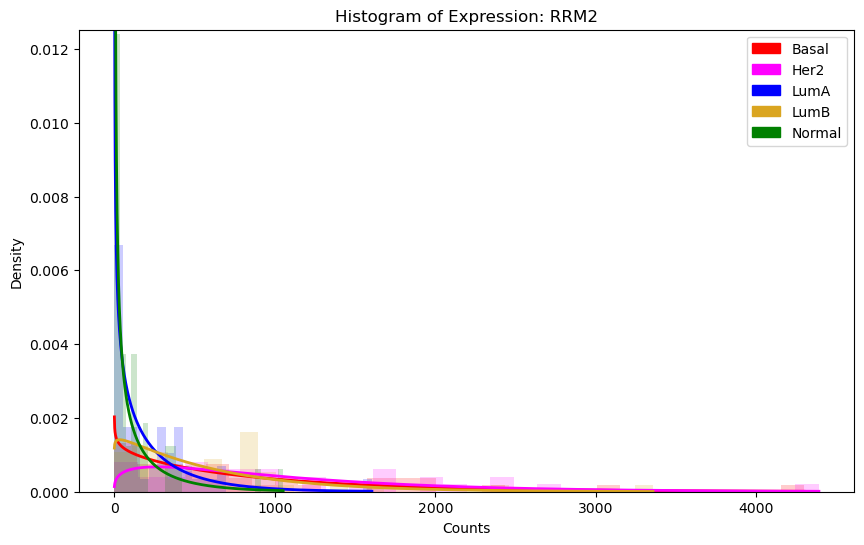

CDC6
Number of zeros in each category:
Categories
Basal     4
Her2      1
LumA      8
LumB      5
Normal    7
Name: Numbers, dtype: int64


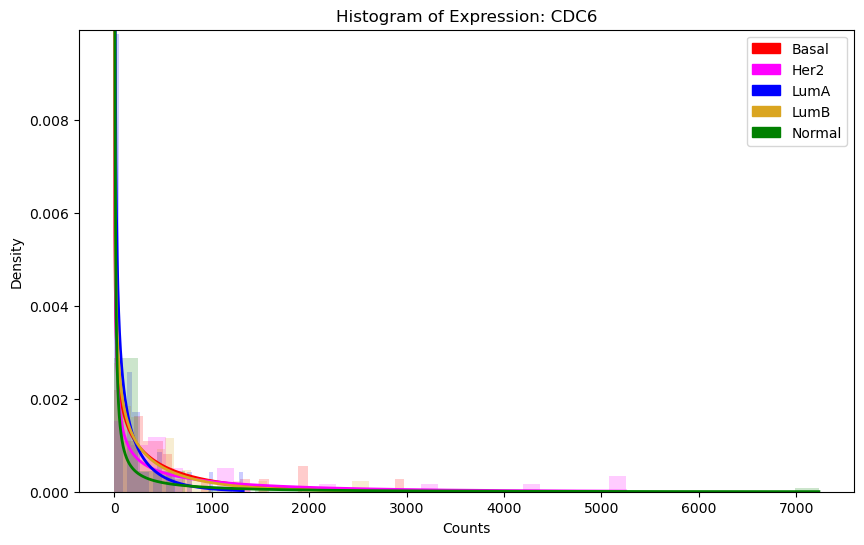

ANLN
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      4
LumB      0
Normal    2
Name: Numbers, dtype: int64


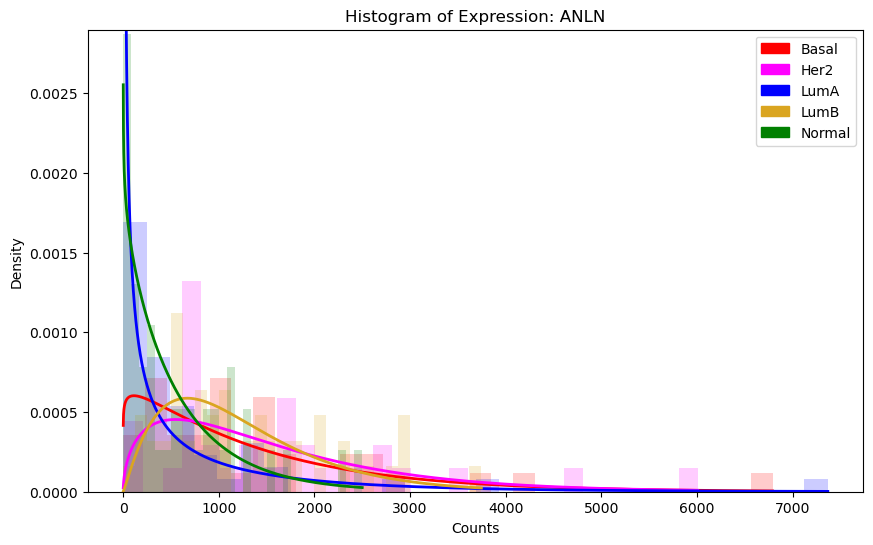

ORC6
Number of zeros in each category:
Categories
Basal     0
Her2      1
LumA      1
LumB      2
Normal    1
Name: Numbers, dtype: int64


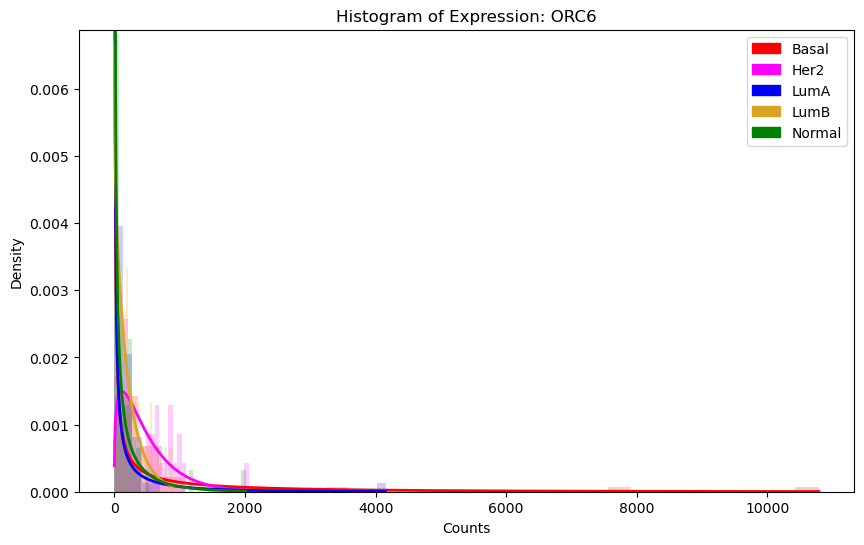

KIF2C
Number of zeros in each category:
Categories
Basal     3
Her2      2
LumA      6
LumB      3
Normal    2
Name: Numbers, dtype: int64


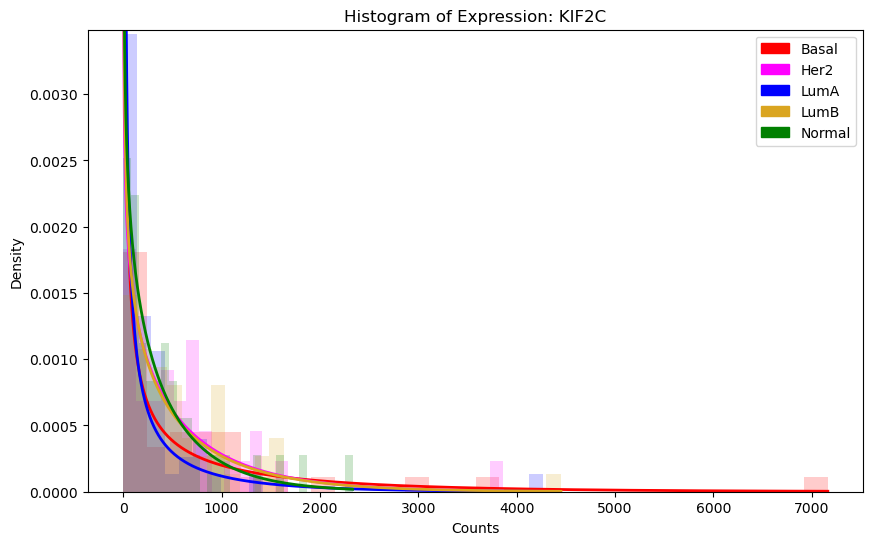

EXO1
Number of zeros in each category:
Categories
Basal      4
Her2       3
LumA      14
LumB       2
Normal    11
Name: Numbers, dtype: int64


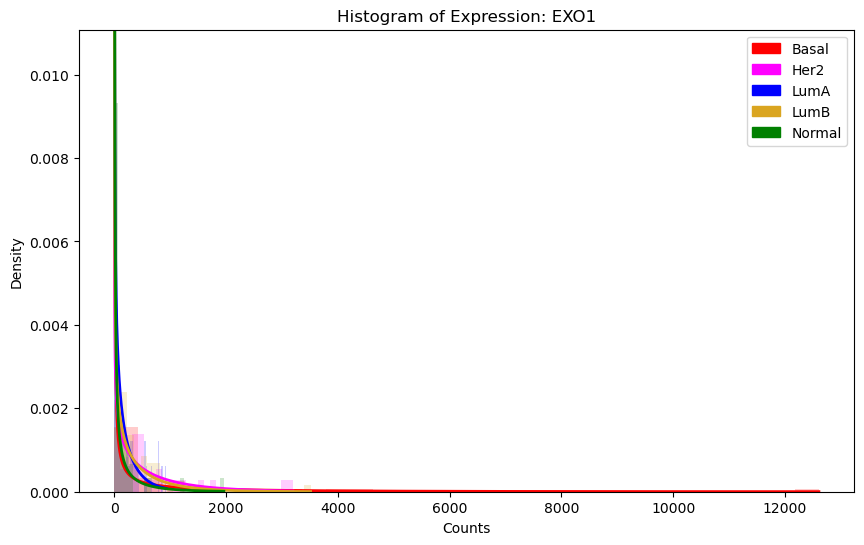

NUF2
Number of zeros in each category:
Categories
Basal      5
Her2       4
LumA      10
LumB       1
Normal     6
Name: Numbers, dtype: int64


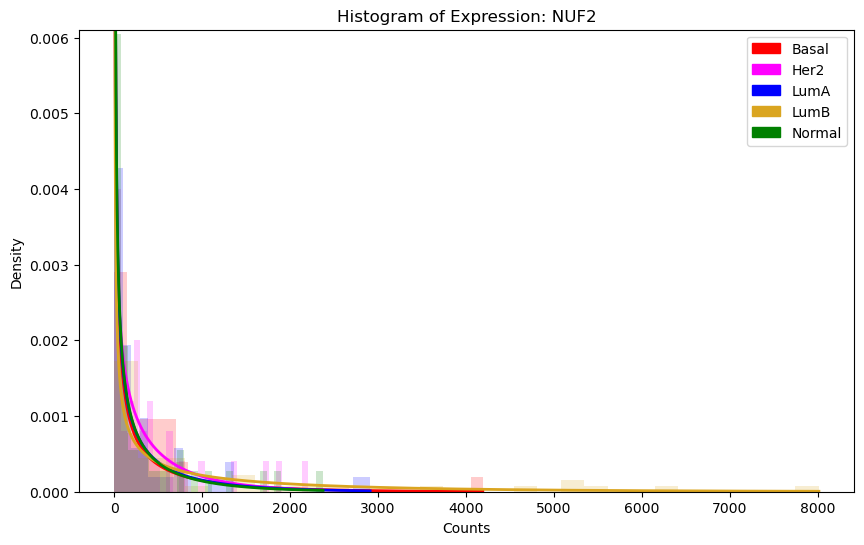

CENPF
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      1
LumB      0
Normal    0
Name: Numbers, dtype: int64


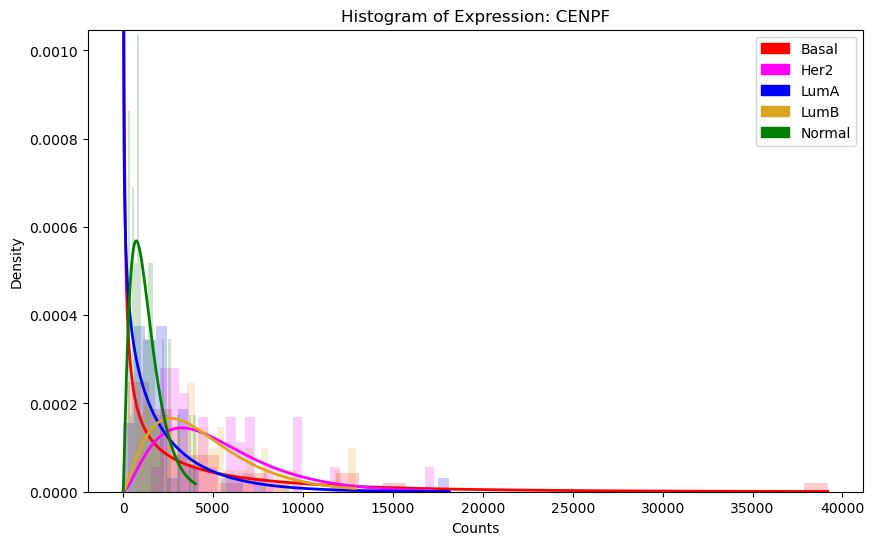

CCNE1
Number of zeros in each category:
Categories
Basal     10
Her2      10
LumA      22
LumB      12
Normal    20
Name: Numbers, dtype: int64


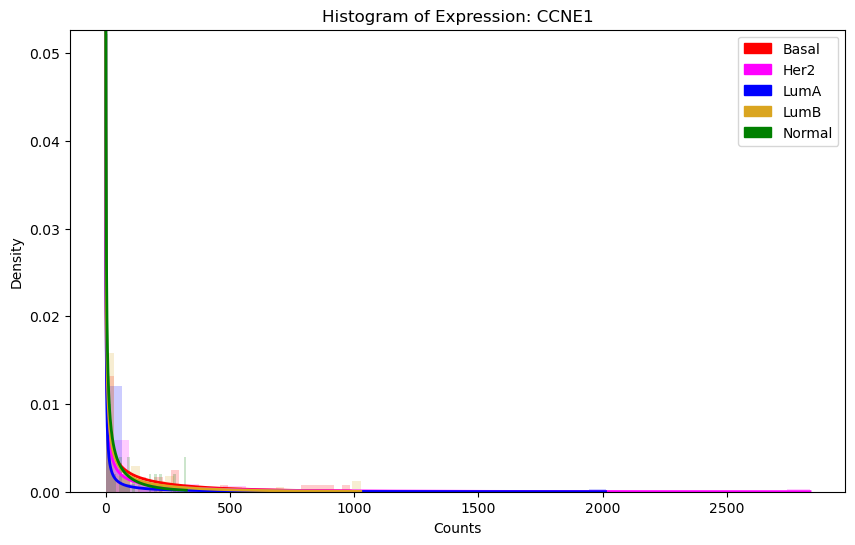

MKI67
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


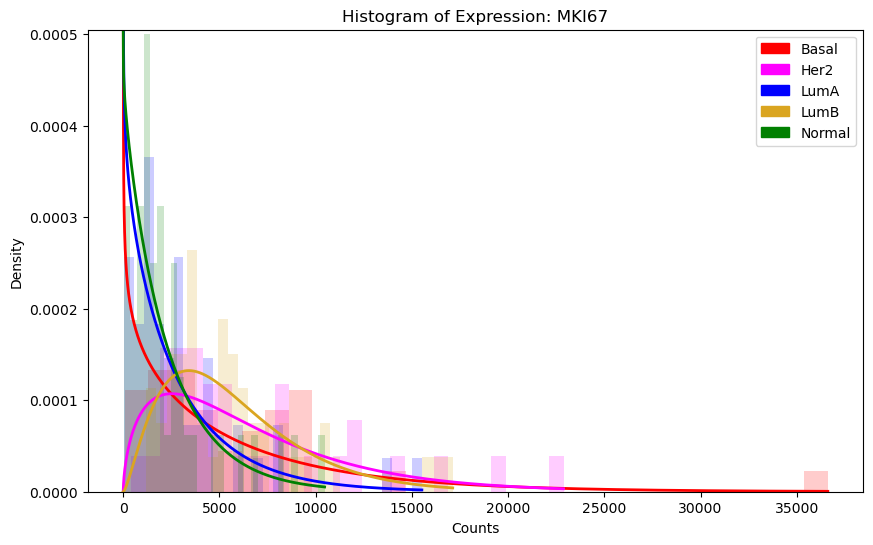

CDC20
Number of zeros in each category:
Categories
Basal     5
Her2      5
LumA      9
LumB      4
Normal    9
Name: Numbers, dtype: int64


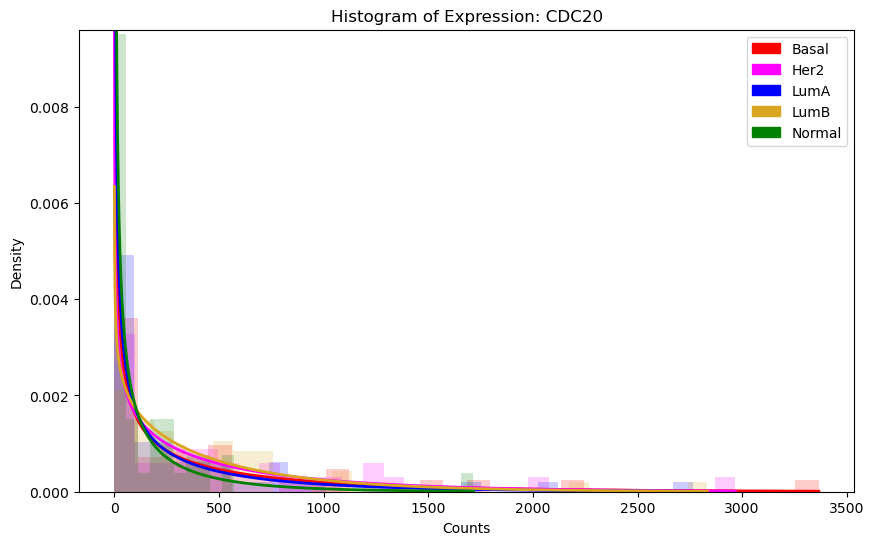

MMP11
Number of zeros in each category:
Categories
Basal     3
Her2      2
LumA      4
LumB      3
Normal    5
Name: Numbers, dtype: int64


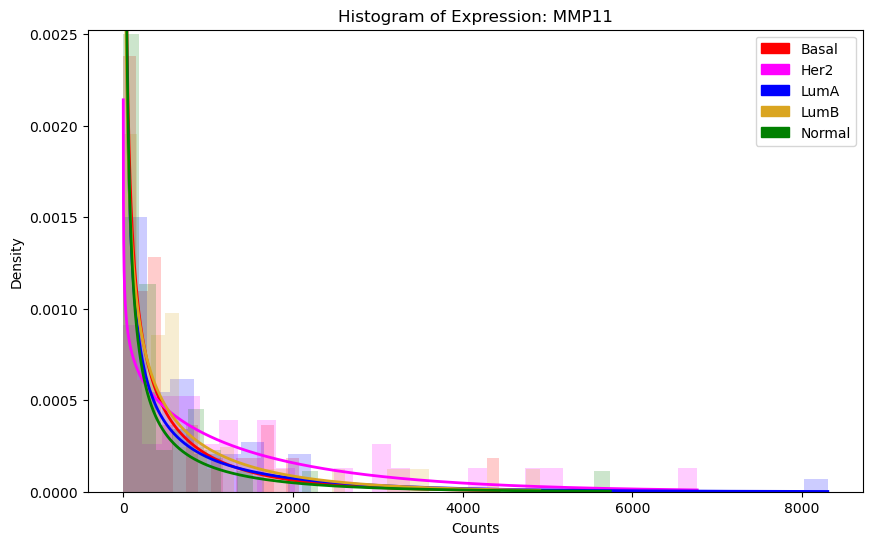

GRB7
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      3
LumB      0
Normal    0
Name: Numbers, dtype: int64


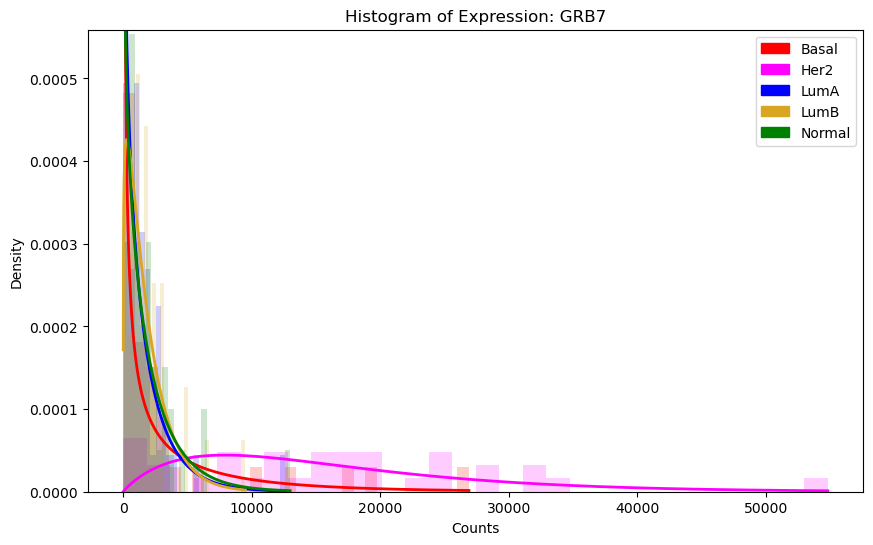

ERBB2
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


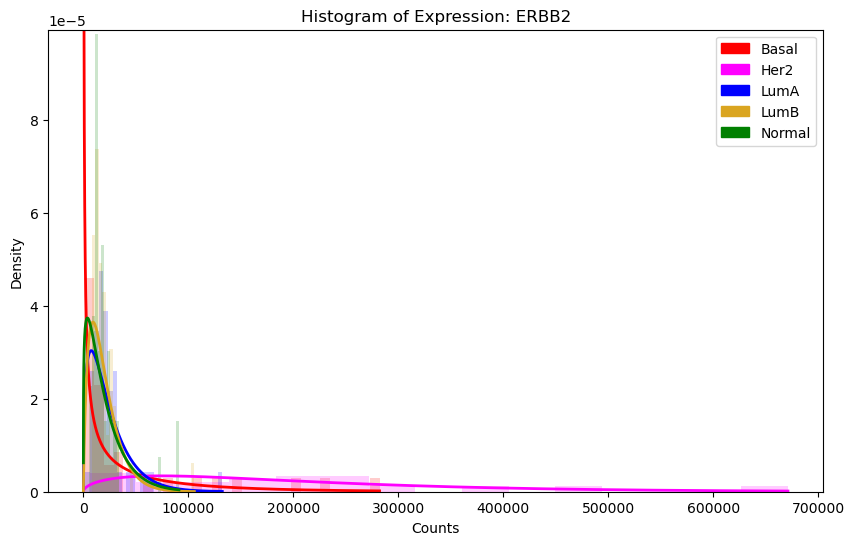

TMEM45B
Number of zeros in each category:
Categories
Basal     5
Her2      2
LumA      7
LumB      4
Normal    4
Name: Numbers, dtype: int64


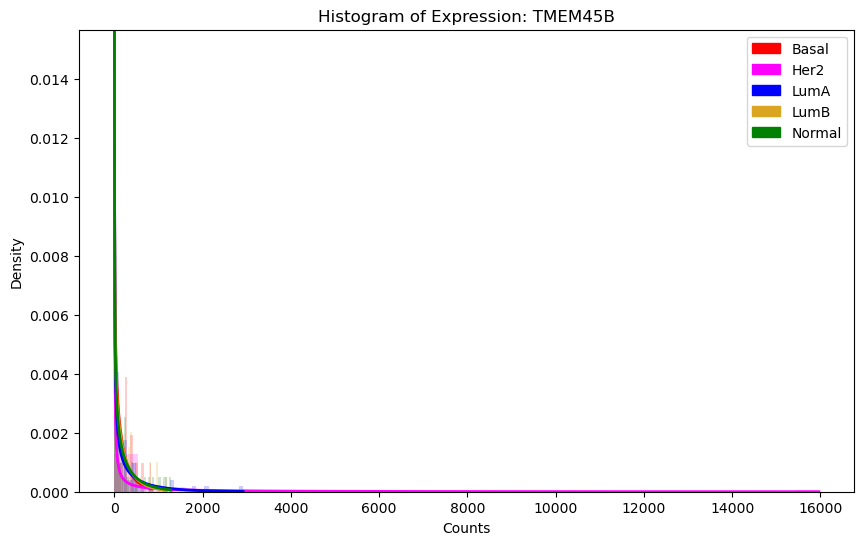

BAG1
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


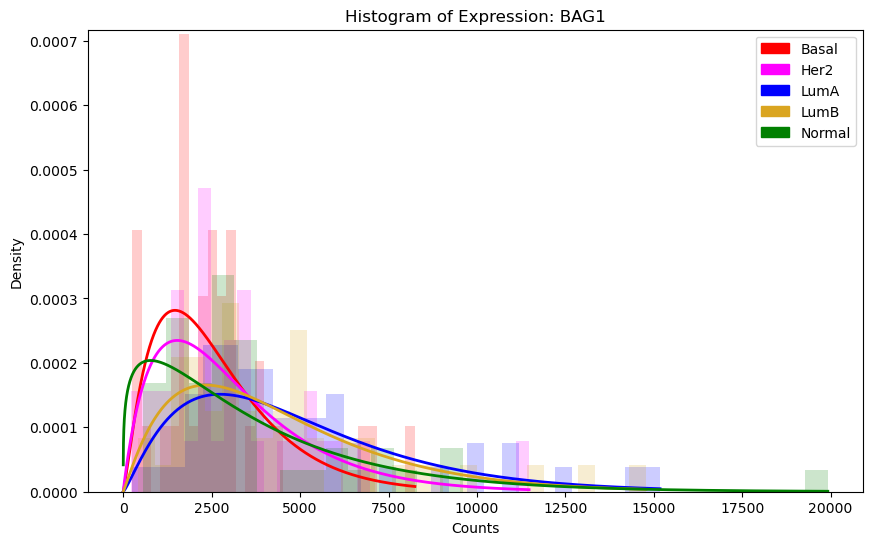

PGR
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


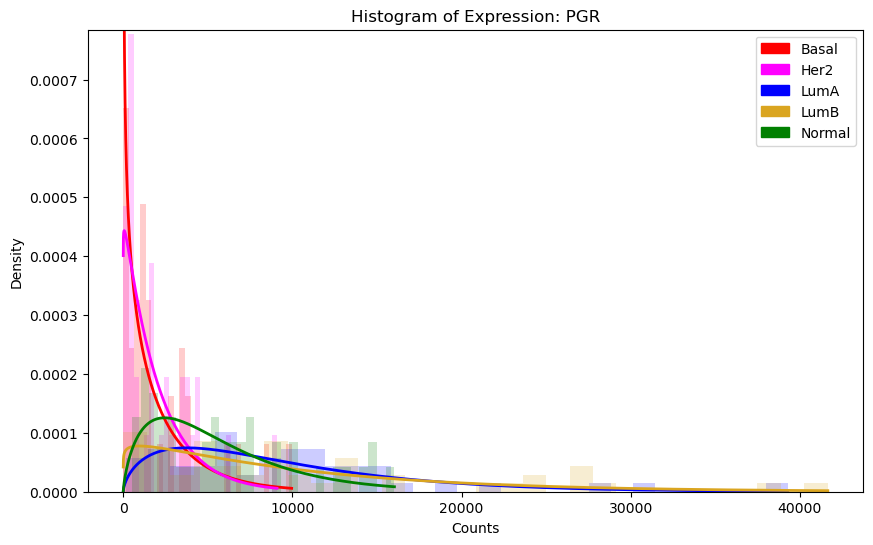

MAPT
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


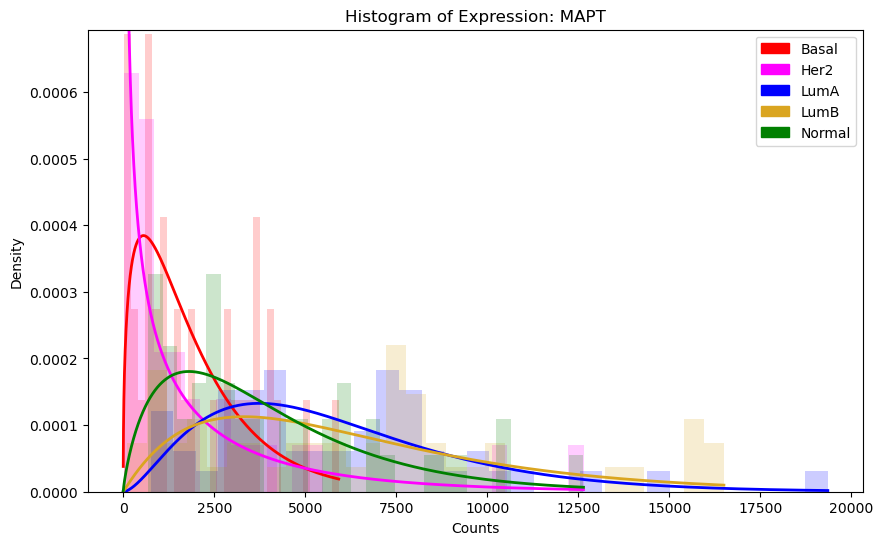

NAT1
Number of zeros in each category:
Categories
Basal     10
Her2       4
LumA       1
LumB       0
Normal     4
Name: Numbers, dtype: int64


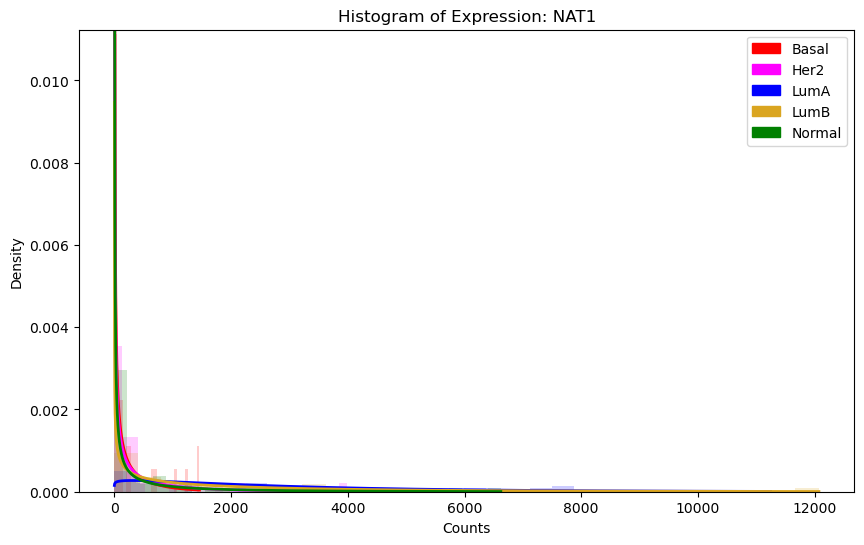

GPR160
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      2
LumB      0
Normal    0
Name: Numbers, dtype: int64


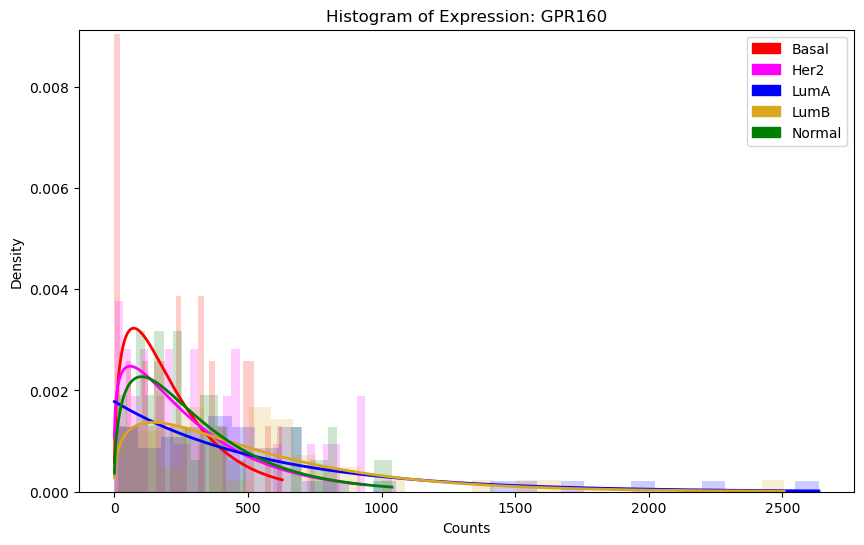

FOXA1
Number of zeros in each category:
Categories
Basal     2
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


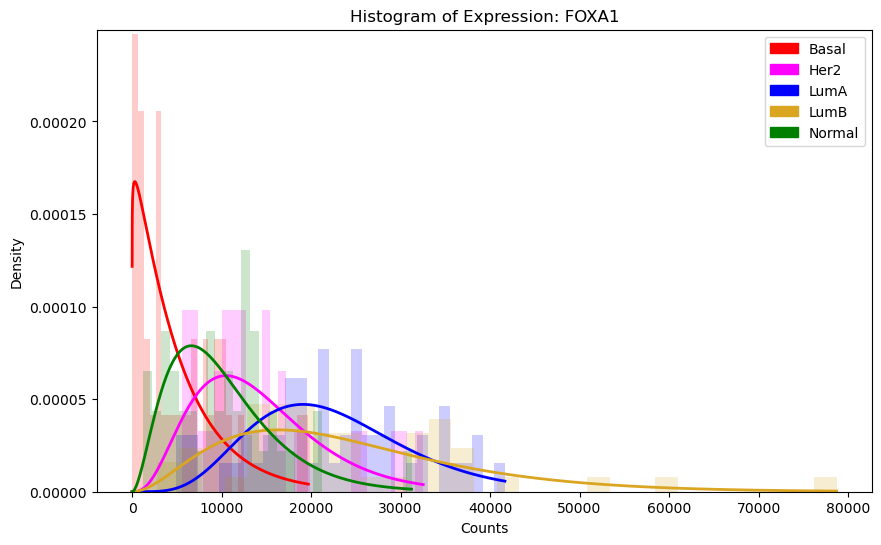

BLVRA
Number of zeros in each category:
Categories
Basal     1
Her2      1
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


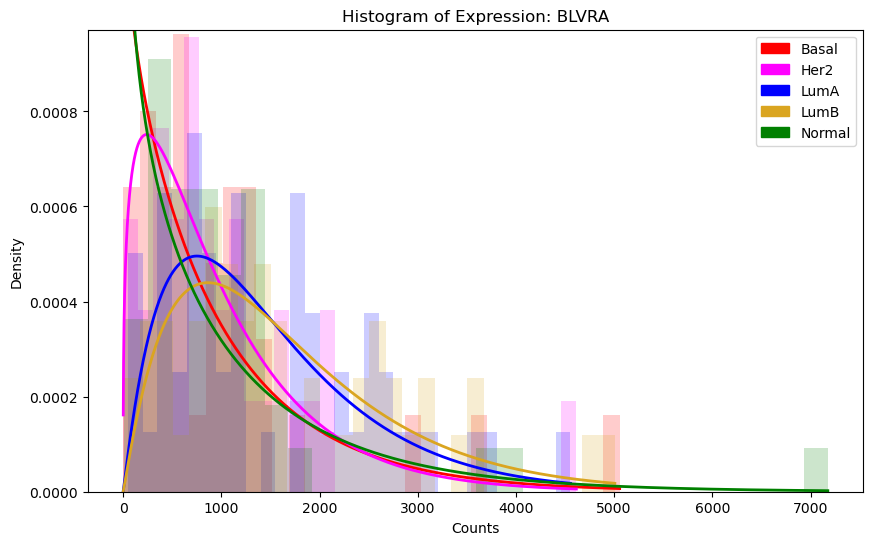

CXXC5
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      1
Normal    0
Name: Numbers, dtype: int64


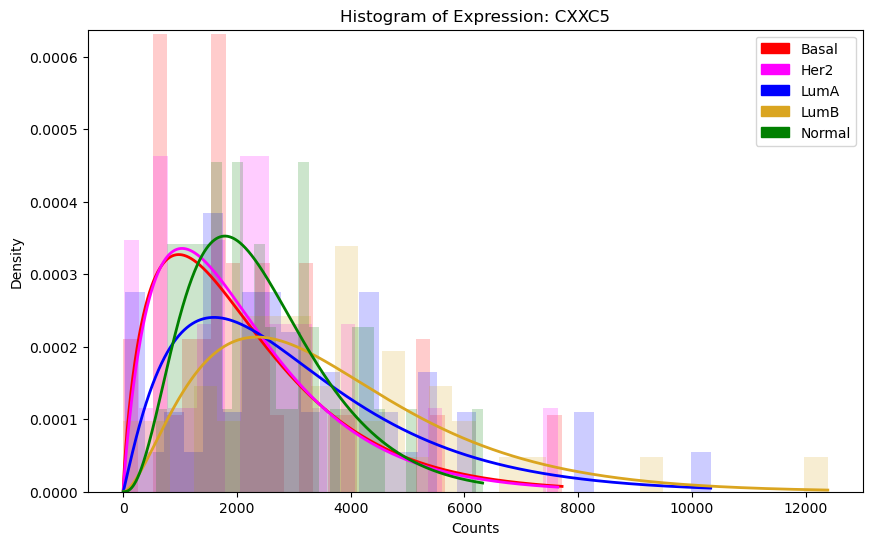

ESR1
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


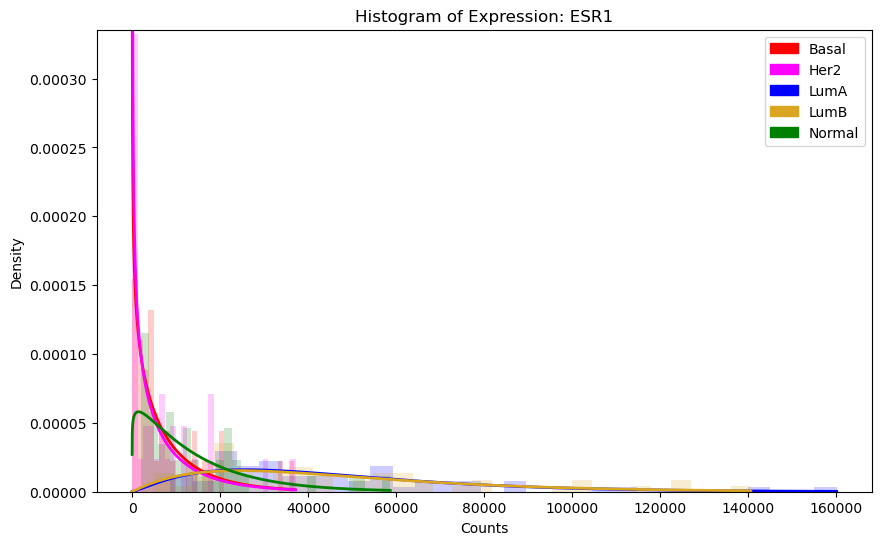

SLC39A6
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


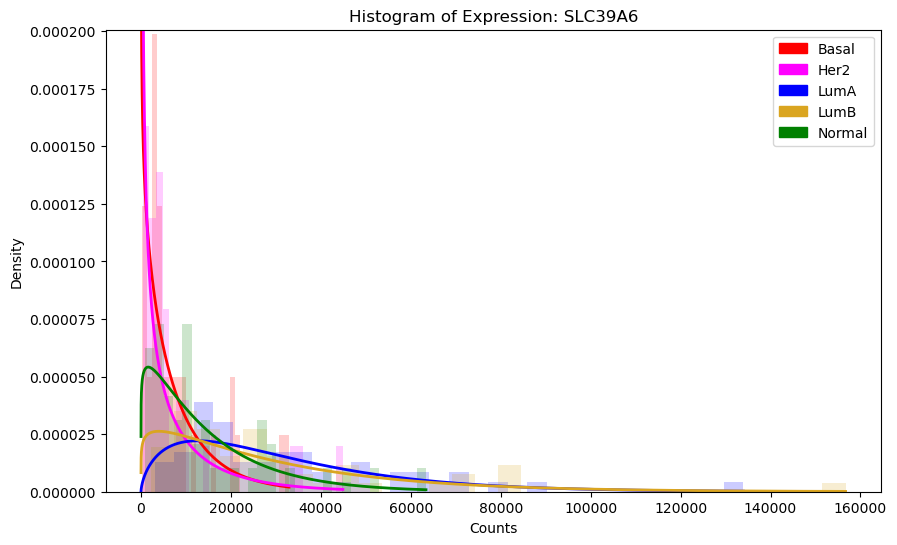

KRT17
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      1
Normal    0
Name: Numbers, dtype: int64


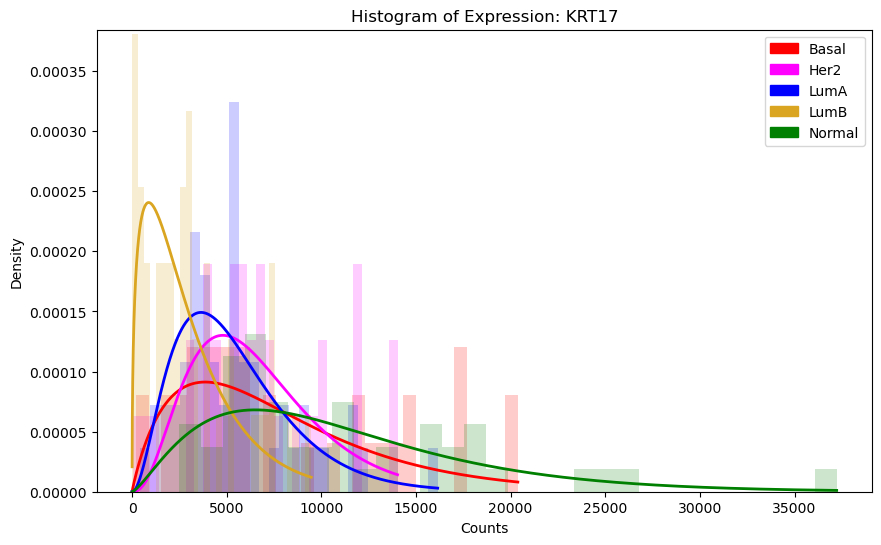

KRT5
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      0
LumB      3
Normal    0
Name: Numbers, dtype: int64


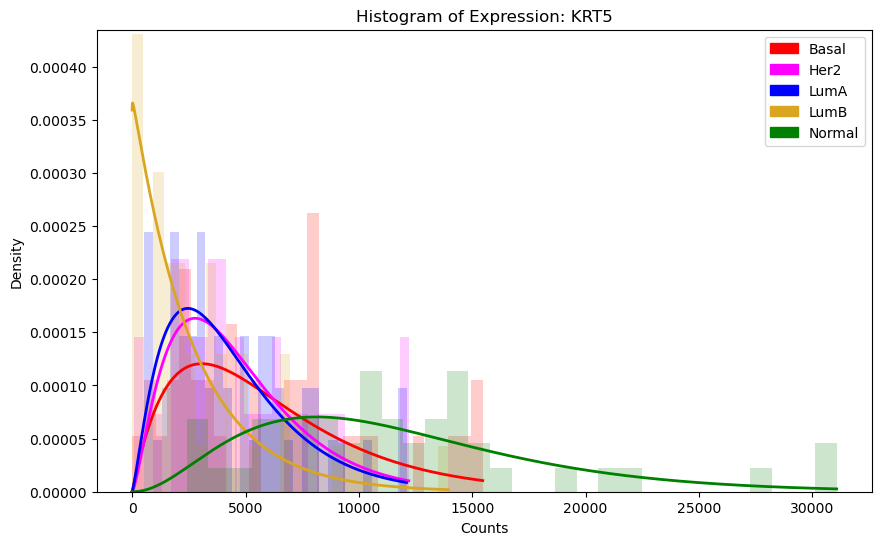

SFRP1
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      3
Normal    0
Name: Numbers, dtype: int64


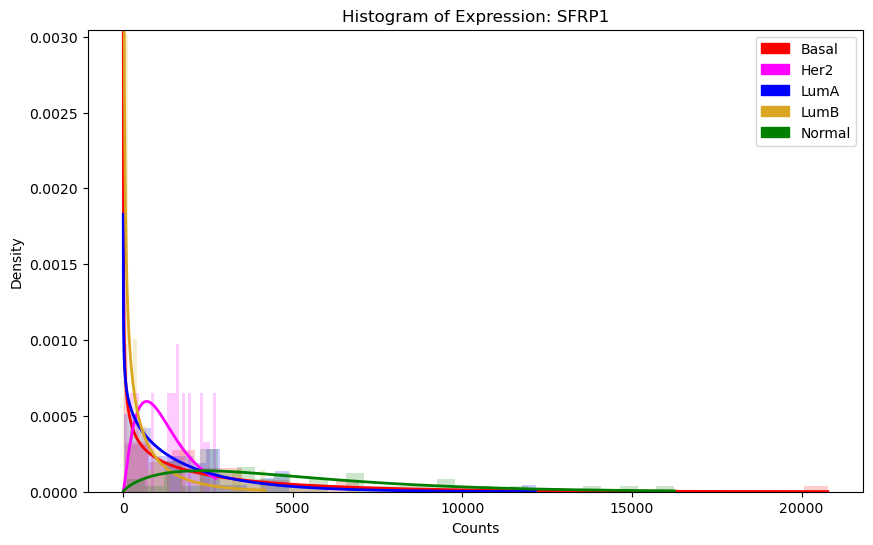

BCL2
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


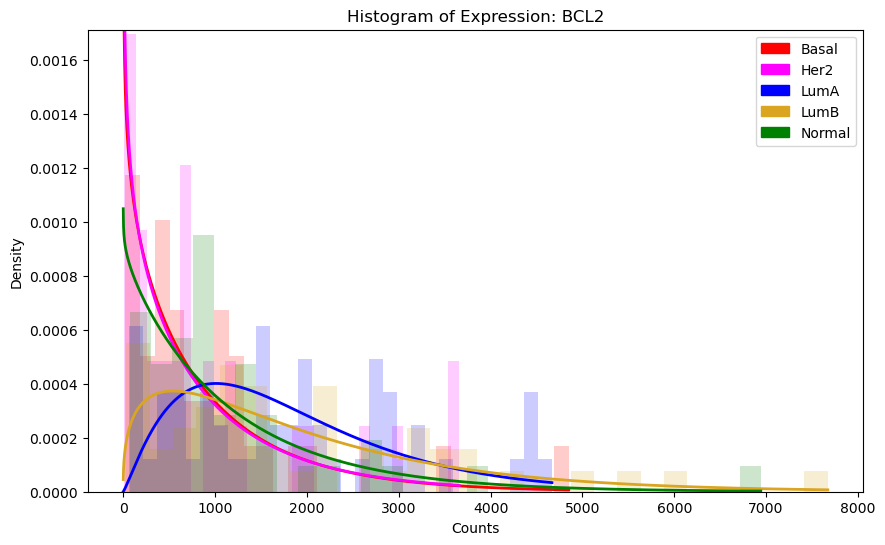

KRT14
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


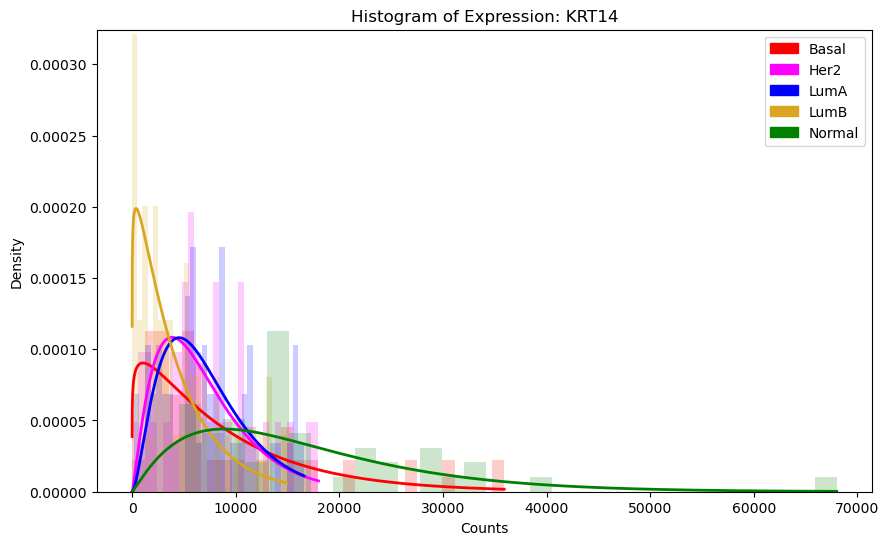

MLPH
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


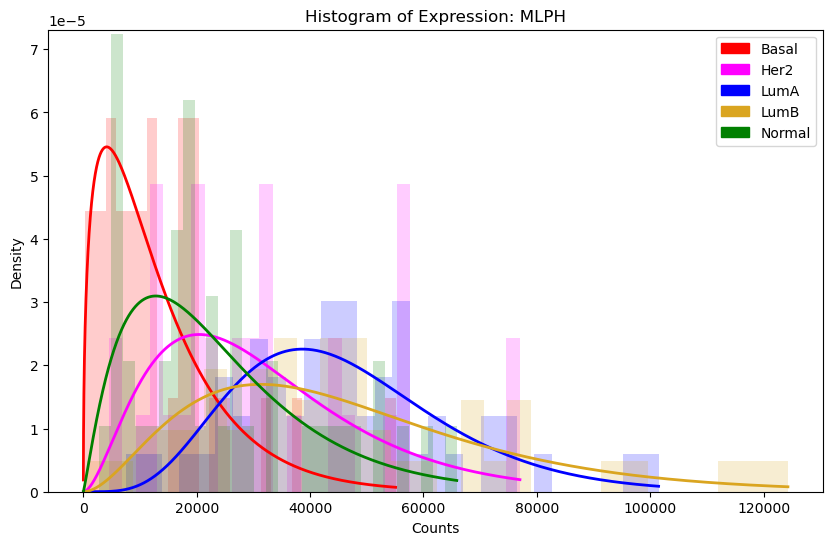

MDM2
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


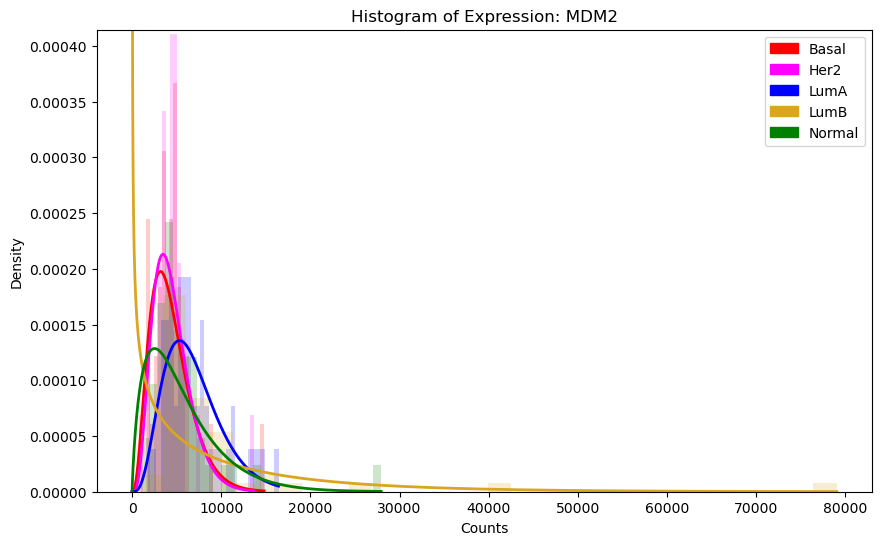

FGFR4
Number of zeros in each category:
Categories
Basal     4
Her2      3
LumA      9
LumB      7
Normal    4
Name: Numbers, dtype: int64


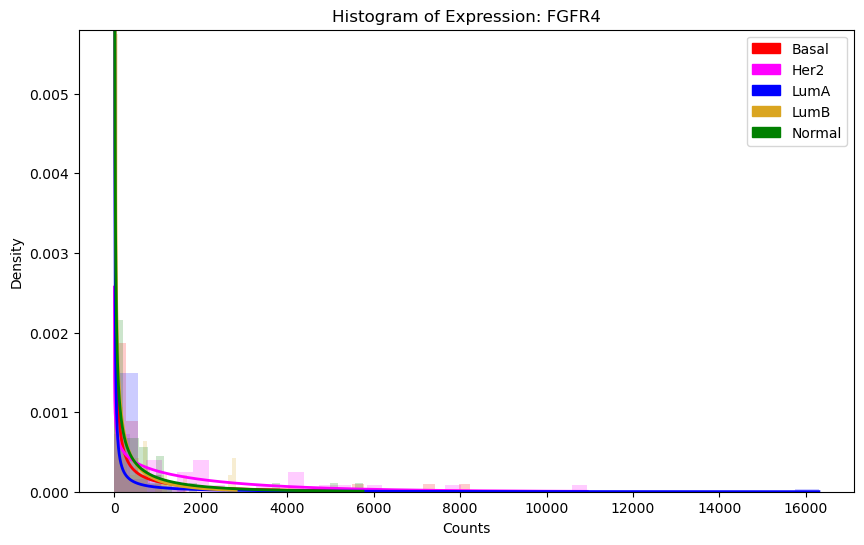

MYC
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      1
Normal    0
Name: Numbers, dtype: int64


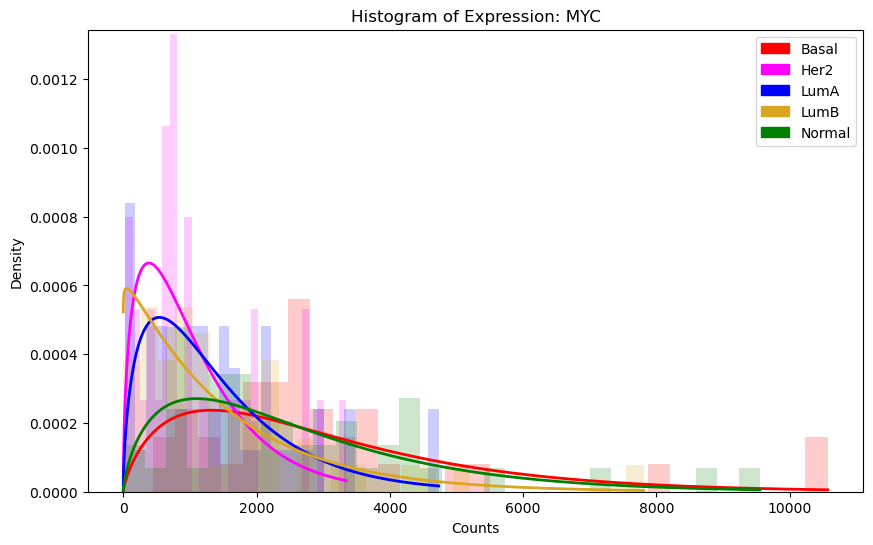

MIA
Number of zeros in each category:
Categories
Basal     24
Her2      26
LumA      36
LumB      33
Normal    26
Name: Numbers, dtype: int64


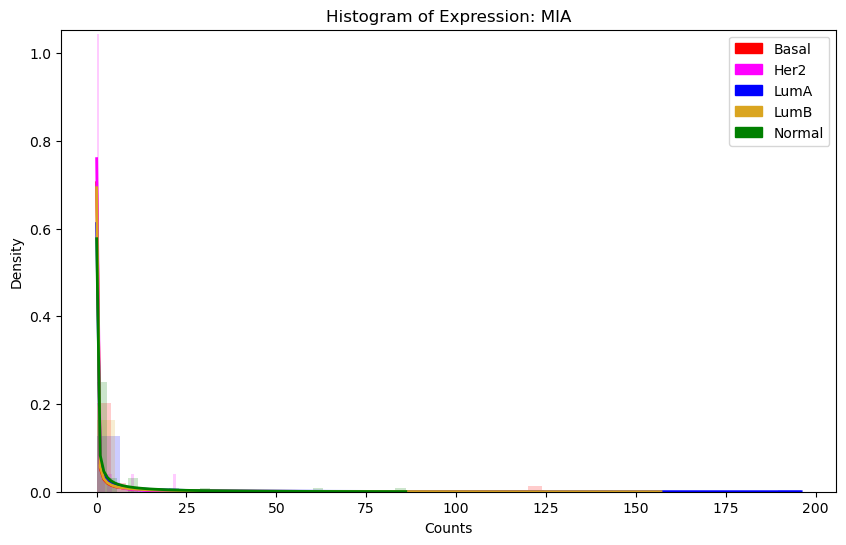

FOXC1
Number of zeros in each category:
Categories
Basal     0
Her2      2
LumA      3
LumB      2
Normal    0
Name: Numbers, dtype: int64


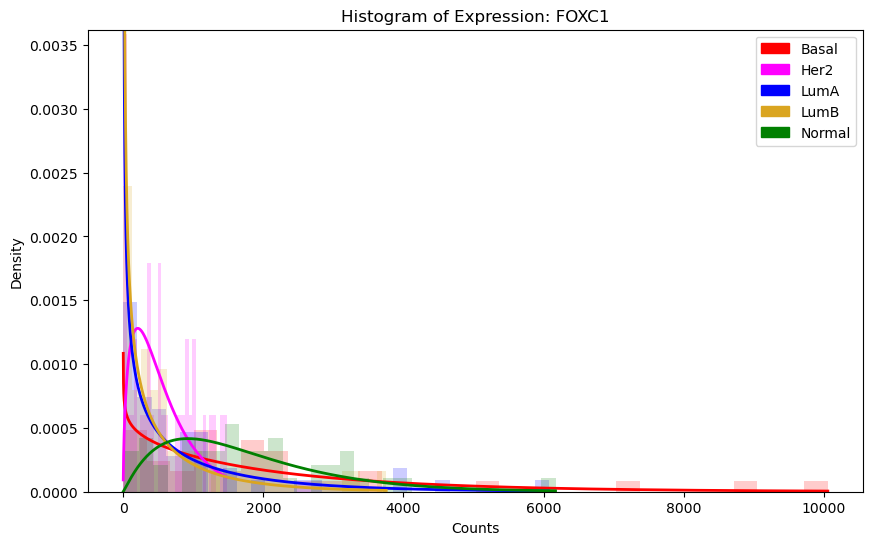

ACTR3B
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


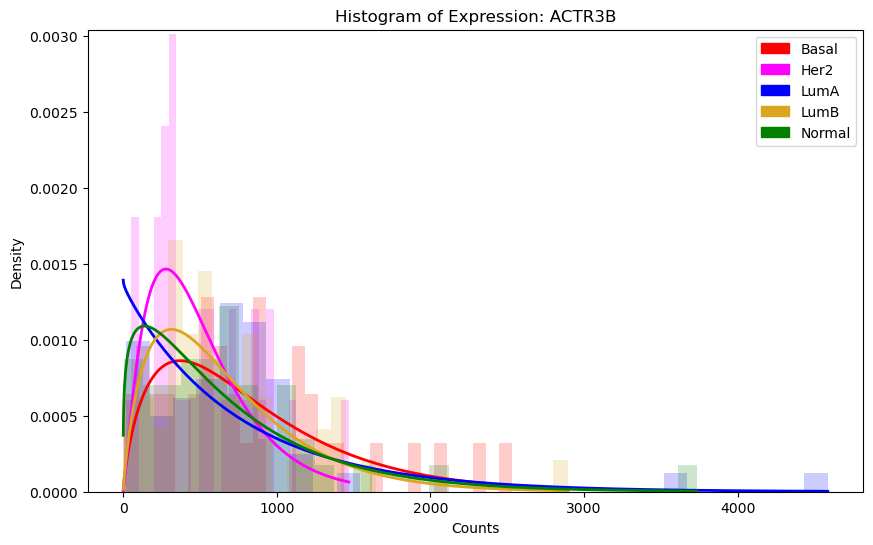

PHGDH
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      2
Normal    0
Name: Numbers, dtype: int64


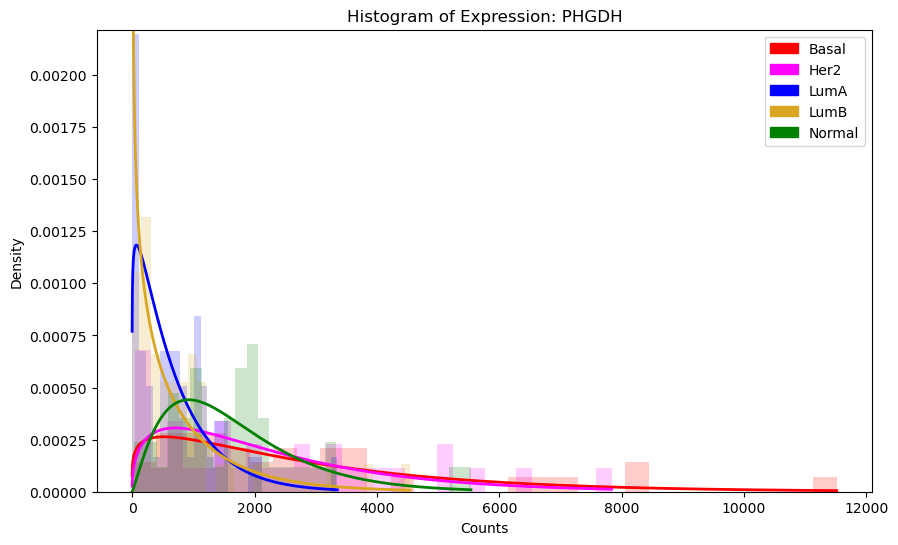

CDH3
Number of zeros in each category:
Categories
Basal     1
Her2      0
LumA      1
LumB      4
Normal    0
Name: Numbers, dtype: int64


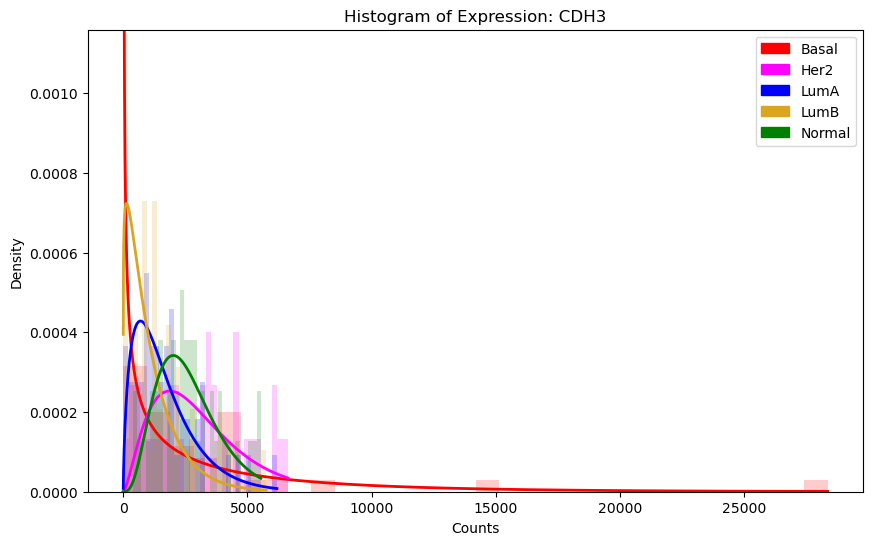

EGFR
Number of zeros in each category:
Categories
Basal     0
Her2      0
LumA      0
LumB      0
Normal    0
Name: Numbers, dtype: int64


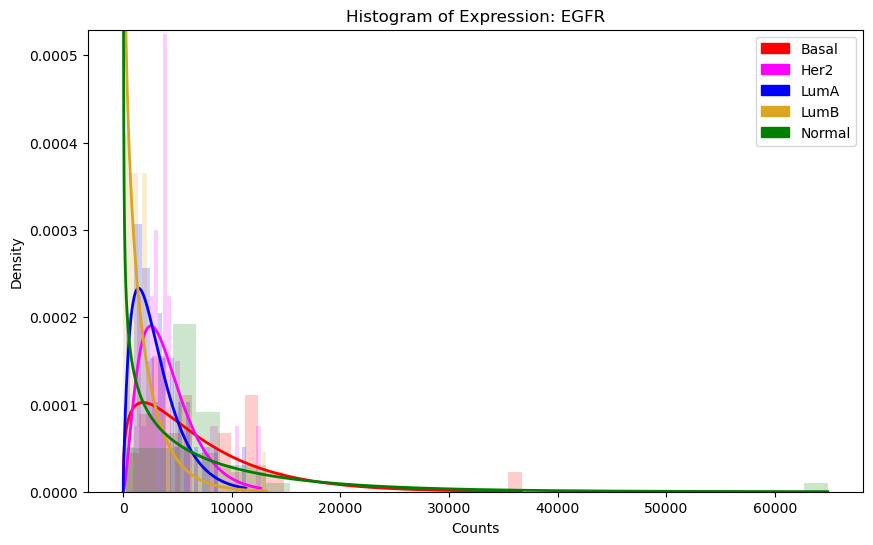

In [24]:
from matplotlib.patches import Patch


count = 0
df_final = pd.DataFrame(columns=['Gene', 'Mean(mu)', 'Variance', 'Dispersion', "p", "r", "const_coeff", "const_pval", "alpha_const", "alpha_pval"])

for gene in present_pam50:
        print(gene)
        gene_data = cleaned_matrix[:, count].flatten()

        count = count + 1
        
        # we split data by subtype
        data = pd.DataFrame({
            'Numbers': gene_data,
            'Categories': subtype_info
        })
        grouped = data.groupby('Categories')['Numbers'].apply(list)
        grouped = grouped[grouped.index != 'NaN']

        colors = ['blue', 'green', 'red', 'cyan', 'magenta']
        categories = grouped.index

        zero_counts = grouped.apply(lambda x: x.count(0))
        print("Number of zeros in each category:")
        print(zero_counts)

        # Apply mean trimming to each category
        trim_percent = 0  # Example trim percent, adjust as needed
        trimmed_grouped = grouped.apply(lambda x: trim_outliers(x, trim_percent))


        # Plot histograms
        plt.figure(figsize=(10, 6))

        colors = ['red', 'magenta', 'blue', 'goldenrod', 'green']
        categories = trimmed_grouped.index

        max_hist_height = 0
        legend_handles = []

        for idx, category in enumerate(categories):
            data = trimmed_grouped[category]
            
            
            # Plot histogram
            num_bins = 30

            if (category == "Her2") and (gene == "ERBB2"):
                  num_bins = 15

            counts, bins, _ = plt.hist(data, bins=num_bins, alpha=0.2, label=category, color=colors[idx % len(colors)], density=True)
        
            max_hist_height = max(max_hist_height, max(counts))

            mu = np.mean(data)
            variance = np.var(data, ddof=1)

            # Calculate dispersion parameter (theta) using method of moments
            theta = mu**2 / (variance - mu)

            # somehow the r paramater is computed the same way
            r = mu**2 / (variance - mu)
            p = r / (r + mu)
            
            x = np.arange(0, np.max(data) + 1)  # Range of values
            fitted_pmf = nbinom.pmf(x, r, p)
    
            plt.plot(x, fitted_pmf, alpha=1, color=colors[idx % len(colors)], linestyle='solid', linewidth=2)
            legend_handles.append(Patch(color=colors[idx % len(colors)], label=category, alpha=1))

        plt.xlabel('Counts')
        plt.ylabel('Density')
        plt.title('Histogram of Expression: ' + gene)
        plt.ylim(0, max_hist_height * 1.01)
        plt.legend(handles=legend_handles)
        plt.show()




In [25]:
# NB parameters
def calculate_probability(theta, mu):
    # Compute the fraction theta / (theta + mu)
    fraction = theta / (theta + mu)
    
    # Raise the fraction to the power of theta
    result = np.power(fraction, theta)
    
    return result

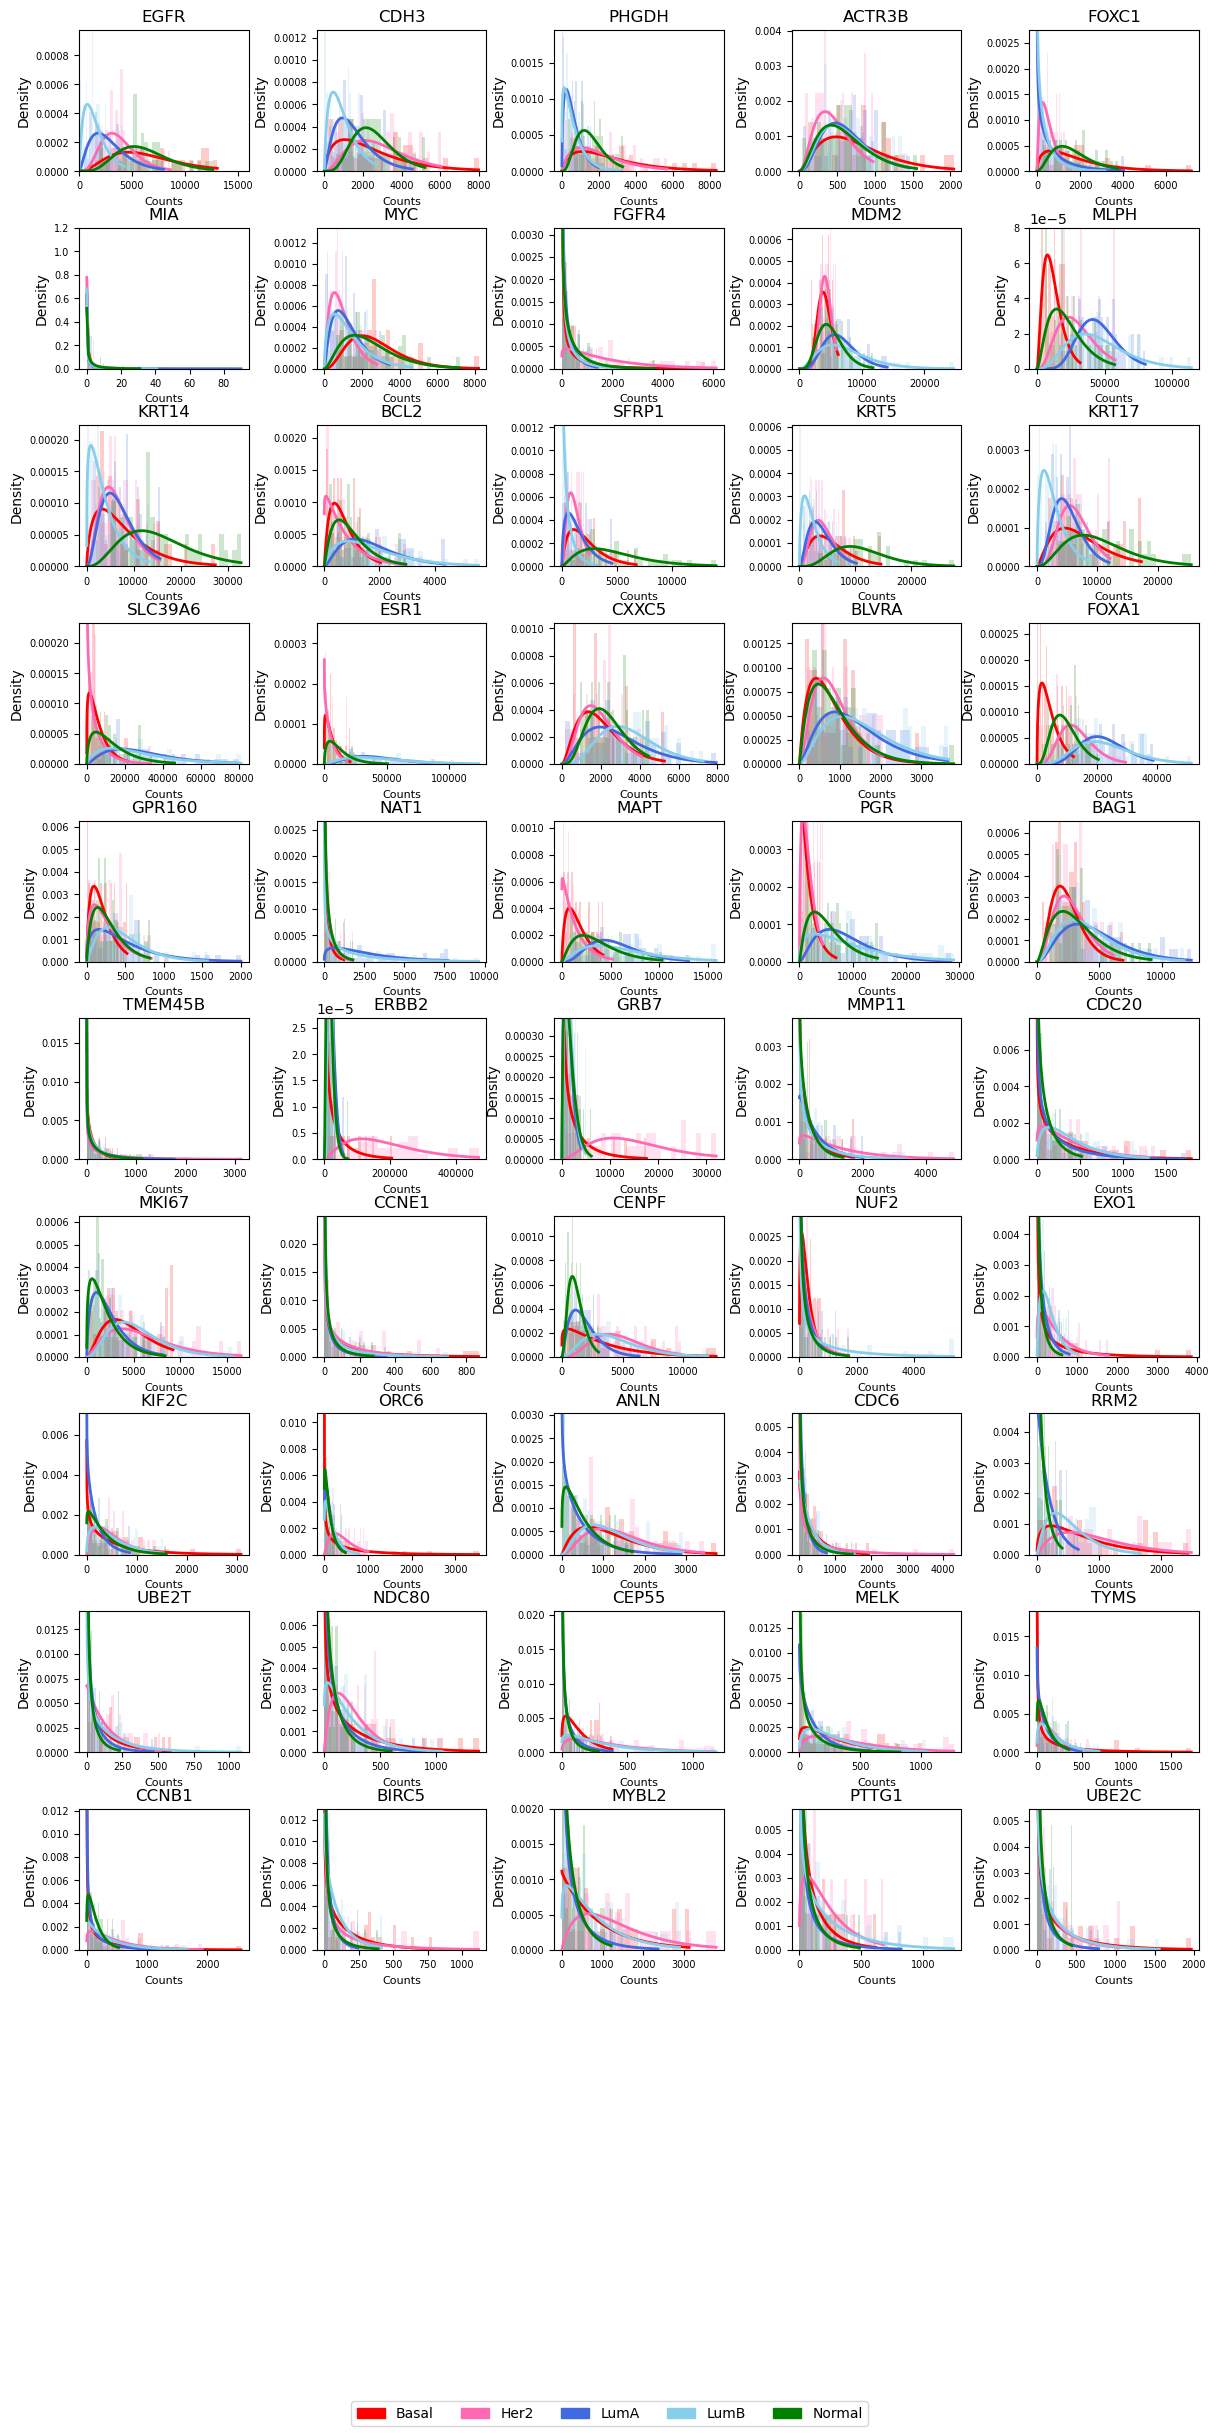

In [ ]:
from matplotlib.patches import Patch

pam50_colors = {
    'LumA': 'royalblue',
    'LumB': 'skyblue',  # Darker yellow (goldenrod)
    'Her2': 'hotpink',
    'Basal': 'red',
    'Normal': 'green'
}


# Create a 5x10 grid of subplots
fig, axes = plt.subplots(10, 5, figsize=(14, 24))
axes = axes.flatten()  # Flatten to easily iterate over the axes

#zero_counts_df = pd.DataFrame(columns=['Gene'] + list(pam50_colors.keys()))
zero_counts_df = pd.DataFrame(columns=['Gene'] + [col + '_zeros' for col in pam50_colors.keys()] + [col + '_Pr(X<0)' for col in pam50_colors.keys()])

for count, gene in enumerate(reversed(present_pam50)):
    if count >= 50:
        break  # Ensure we only create up to 50 plots

    gene_data = cleaned_matrix[:, 49 - count].flatten()

    # Split data by subtype
    data = pd.DataFrame({
        'Numbers': gene_data,
        'Categories': subtype_info
    })
    grouped = data.groupby('Categories')['Numbers'].apply(list)
    grouped = grouped[grouped.index != 'NaN']



    # Apply mean trimming to each category
    # We decided not to do this anymore, but I do want to use some of the code to control the x-axis length
    trim_percent = 3  ##########
    trimmed_grouped = grouped.apply(lambda x: trim_outliers(x, trim_percent))

    # Select the subplot
    ax = axes[count]

    max_hist_height = 0
    legend_handles = []
    prob_zero_row = {'Gene': gene}
    zero_counts_row = {'Gene': gene}

    for category in grouped.index:
        
        if category not in pam50_colors:
            continue  # Skip categories not in the PAM50 list

        color = pam50_colors[category]
        data = trimmed_grouped[category]
        

        # Plot histogram
        num_bins = 30

        if (category == "Her2") and (gene == "ERBB2"):
            num_bins = 15

        counts, bins, _ = ax.hist(data, bins=num_bins, alpha=0.2, label=category, color=color, density=True)
        max_hist_height = max(max_hist_height, max(counts))

        mu = np.mean(data)
        variance = np.var(data, ddof=1)

        # Calculate dispersion parameter (theta) using method of moments
        theta = mu**2 / (variance - mu)

        # somehow the r paramater is computed the same way
        r = mu**2 / (variance - mu)
        p = r / (r + mu)
        
        # probability of zero
        p_zero_1 = calculate_probability(theta, mu)

        # what about the Svennson formula
        variance = np.var(data, ddof=1) # “Delta Degrees of Freedom”
        mean = np.mean(data)
        std_dev = np.sqrt(variance) # sometimes this is considered dispersion
        dispersion = 0 # in case the mean is zero, or if variance = mean
        if ((mean != 0) & (variance != mean)):
            #dispersion = (variance - mean)/(mean**2)
            dispersion = (mean**2)/(variance - mean) # did I have this backwards?
            inverse_dispersion = dispersion**-1
        
        # and they define "expected fraction zeros" as exp(-mean) - Poisson distribution!
        #prob_frac = math.exp(mean*-1)
        
        # lets do the NB formulation
        prob_frac = 1 # if dispersion is zero, the fraction zero is 100%
        if (dispersion >0):
            prob_frac = ((inverse_dispersion)/(mean + inverse_dispersion))**(inverse_dispersion)

        
        category_prob_zeroes = category + "_Pr(X<0)"
        # I find Dr. Hallett's way works much closer to the data
        
        prob_zero_row[category_prob_zeroes] = f"{p_zero_1:.3f}"
        
        # lets count zeroes
        zero_fract = np.count_nonzero(data == 0) / len(data)
        category_zeroes = category + "_zeros"
        zero_counts_row[category_zeroes] = f"{zero_fract:.3f}"
        #print(gene, category, f"{zero_fract:.3f}", f"{p_zero_1:.3e}", f"{prob_frac:.3e}")

        # and finalize line plot
        x = np.arange(0, np.max(data) + 1)  # Range of values
        fitted_pmf = nbinom.pmf(x, r, p)
        ax.plot(x, fitted_pmf, alpha=1, color=color, linestyle='solid', linewidth=2)
        #plt.plot(x, fitted_pmf, alpha=1, color=colors[idx % len(colors)], linestyle='solid', linewidth=2)
        legend_handles.append(Patch(color=color, label=category, alpha=1))

    all_data = {**zero_counts_row, **prob_zero_row}

    #zero_counts_df = zero_counts_df.append(all_data, ignore_index=True)
    all_data_df = pd.DataFrame([all_data])

    # Now concatenate with 'zero_counts_df'
    zero_counts_df = pd.concat([zero_counts_df, all_data_df], ignore_index=True)

    ax.set_xlabel('Counts', fontsize = 8)
    ax.set_ylabel('Density')
    ax.set_title(gene)
    
    # Set y-axis limit to 1.1 times the maximum height of the histogram
    if (gene == "NDC80") or (gene == "NUF2") or (gene == "GRB7") or (gene == "FGFR4") or (gene == "SFRP1") or (gene == "CEP55") or (gene == "PGR") or (gene == "CDC20") or (gene == "CDC6") or (gene == "CCNE1"):        
        ax.set_ylim(0, max_hist_height * 0.4)
    elif (gene == "MIA") or (gene == "BIRC5") or (gene == "UBE2C") or (gene == "UBE2T") or (gene == "ERBB2") or (gene == "EXO1") or (gene == "RRM2") or (gene == "NAT1") or (gene == "MYBL2") or (gene == "PTTG1"):
        ax.set_ylim(0, max_hist_height * 0.2)
    else:
        ax.set_ylim(0, max_hist_height * 0.9)
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

    if (gene == "EGFR"):
        ax.set_xlim(0, 16000)

# zero table

zero_counts_df.to_csv('/path/to/6_dispersion/9_Exploring_NB_In_PAM50/PAM50_DCIS_Zeroes_vs_Probability_Zeroes.test.csv', index=False)

# Create a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, labels, loc='lower center', ncol=len(pam50_colors))
#plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.2, wspace=0.4, hspace=0.4)

plt.savefig('/path/to/6_dispersion/9_Exploring_NB_In_PAM50/All_PAM50_Genes.DCIS.By_Subtype.test.pdf')
plt.show()

In [ ]:
differences = pd.DataFrame()

differences['LumA'] = zero_counts_df['LumA_zeros'].astype(float) - zero_counts_df['LumA_Pr(X<0)'].astype(float)
differences['LumB'] = zero_counts_df['LumB_zeros'].astype(float) - zero_counts_df['LumB_Pr(X<0)'].astype(float)
differences['Her2'] = zero_counts_df['Her2_zeros'].astype(float) - zero_counts_df['Her2_Pr(X<0)'].astype(float)
differences['Basal'] = zero_counts_df['Basal_zeros'].astype(float) - zero_counts_df['Basal_Pr(X<0)'].astype(float)
differences['Normal'] = zero_counts_df['Normal_zeros'].astype(float) - zero_counts_df['Normal_Pr(X<0)'].astype(float)

# bar chart of the differences
ax = differences.plot(kind='bar', figsize=(15, 8), color=[pam50_colors[col] for col in differences.columns])

# Setting the X-axis labels
ax.set_xticklabels(zero_counts_df['Gene'], rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('True Zero Fraction per subtype - Probability(X=0) by NB')
plt.xlabel('Genes')
plt.ylabel('Fraction Zeroes - Probability Zeroes')
plt.tight_layout()
plt.savefig('/path/to/6_dispersion/9_Exploring_NB_In_PAM50/All_PAM50_Genes.DCIS.By_Subtype.Fraction_vs_Predicted_Zeroes.pdf')
plt.show()

In [ ]:
# version with limited gene set

from matplotlib.patches import Patch

pam50_colors = {
    'LumA': 'royalblue',
    'LumB': 'skyblue',  # Darker yellow (goldenrod)
    'Her2': 'hotpink',
    'Basal': 'red',
    'Normal': 'green'
}

#genes_of_interest = ["EGFR", "ESR1", "ERBB2", "GRB7", "PGR", "MKI67", "KRT5", "FOXA1", "ANLN", "CENPF"]
genes_of_interest = ["EGFR", "ESR1", "ERBB2", "GRB7", "KRT5"]

# Create a 5x10 grid of subplots
fig, axes = plt.subplots(5, 1, figsize=(4, 10))
axes = axes.flatten()  # Flatten to easily iterate over the axes

axes_count = -1 # need to start at -1 as count++ happens first

#zero_counts_df = pd.DataFrame(columns=['Gene'] + list(pam50_colors.keys()))
zero_counts_df = pd.DataFrame(columns=['Gene'] + [col + '_zeros' for col in pam50_colors.keys()] + [col + '_Pr(X<0)' for col in pam50_colors.keys()])

for count, gene in enumerate(present_pam50):
    if count >= 50:
        break  # Ensure we only create up to 50 plots
    

    if gene not in genes_of_interest:
        # Skip genes we aren't interested in
        continue
    else:
        axes_count += 1


    gene_data = cleaned_matrix[:, count].flatten()

    # Split data by subtype
    data = pd.DataFrame({
        'Numbers': gene_data,
        'Categories': subtype_info
    })
    grouped = data.groupby('Categories')['Numbers'].apply(list)
    grouped = grouped[grouped.index != 'NaN']



    # Apply mean trimming to each category
    # We decided not to do this anymore, but I do want to use some of the code to control the x-axis length
    trim_percent = 10  # Example trim percent, adjust as needed
    trimmed_grouped = grouped.apply(lambda x: trim_outliers(x, trim_percent))

    # Select the subplot
    ax = axes[axes_count]

    max_hist_height = 0
    legend_handles = []
    prob_zero_row = {'Gene': gene}
    zero_counts_row = {'Gene': gene}

    for category in grouped.index:
        
        if category not in pam50_colors:
            continue  # Skip categories not in the PAM50 list

        color = pam50_colors[category]
        data = trimmed_grouped[category]
        

        # Plot histogram
        num_bins = 30

        if (category == "Her2") and (gene == "ERBB2"):
            num_bins = 15

        counts, bins, _ = ax.hist(data, bins=num_bins, alpha=0.2, label=category, color=color, density=True)
        max_hist_height = max(max_hist_height, max(counts))

        mu = np.mean(data)
        variance = np.var(data, ddof=1)

        # Calculate dispersion parameter (theta) using method of moments
        theta = mu**2 / (variance - mu)

        # somehow the r paramater is computed the same way
        r = mu**2 / (variance - mu)
        p = r / (r + mu)
        
        # probability of zero
        p_zero_1 = calculate_probability(theta, mu)

        # what about the Svennson formula
        variance = np.var(data, ddof=1) # “Delta Degrees of Freedom”
        mean = np.mean(data)
        std_dev = np.sqrt(variance) # sometimes this is considered dispersion
        dispersion = 0 # in case the mean is zero, or if variance = mean
        if ((mean != 0) & (variance != mean)):
            #dispersion = (variance - mean)/(mean**2)
            dispersion = (mean**2)/(variance - mean) # did I have this backwards?
            inverse_dispersion = dispersion**-1
        
        # and they define "expected fraction zeros" as exp(-mean) - Poisson distribution!
        #prob_frac = math.exp(mean*-1)
        
        # lets do the NB formulation
        prob_frac = 1 # if dispersion is zero, the fraction zero is 100%
        if (dispersion >0):
            prob_frac = ((inverse_dispersion)/(mean + inverse_dispersion))**(inverse_dispersion)

        
        category_prob_zeroes = category + "_Pr(X<0)"
        # I find Dr. Hallett's way works much closer to the data
        
        prob_zero_row[category_prob_zeroes] = f"{p_zero_1:.3f}"
        
        # lets count zeroes
        zero_fract = np.count_nonzero(data == 0) / len(data)
        category_zeroes = category + "_zeros"
        zero_counts_row[category_zeroes] = f"{zero_fract:.3f}"
        # print(gene, category, f"{zero_fract:.3f}", f"{p_zero_1:.3e}", f"{prob_frac:.3e}")

        # and finalize line plot
        x = np.arange(0, np.max(data) + 1)  # Range of values
        fitted_pmf = nbinom.pmf(x, r, p)
        ax.plot(x, fitted_pmf, alpha=1, color=color, linestyle='solid', linewidth=2)
        #plt.plot(x, fitted_pmf, alpha=1, color=colors[idx % len(colors)], linestyle='solid', linewidth=2)
        legend_handles.append(Patch(color=color, label=category, alpha=1))

    all_data = {**zero_counts_row, **prob_zero_row}

    zero_counts_df = zero_counts_df.append(all_data, ignore_index=True)

    ax.set_xlabel('Counts')
    ax.set_ylabel('Density')
    if (gene == "ERBB2"):
        ax.set_title("ERBB2 (HER2)")
    else:
        ax.set_title(gene)
    
    # Set y-axis limit to 1.1 times the maximum height of the histogram
    if (gene == "ERBB2"):
        ax.set_ylim(0, max_hist_height * 0.25)
    elif (gene == "GRB7") or (gene == "ESR1"):
        ax.set_ylim(0, max_hist_height * 0.60)
    else: 
        ax.set_ylim(0, max_hist_height * 0.9)
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

# zero table

# Create a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, labels, loc='lower center', ncol=len(pam50_colors))
#plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.2, wspace=0.4, hspace=0.4)

plt.savefig('/path/to/6_dispersion/9_Exploring_NB_In_PAM50/All_PAM50_Genes.DCIS.By_Subtype.Set_of_5.pdf')
plt.show()